**브런치 사용자를 위한 글 및 작가 추천 전처리 및 EDA**

*Table of Contents*
1. 필요모듈 import & <Data, Column> 설명
2. Data Read & Data Preprocessing
3. EDA
4. Train Data & Test Data
---

# 필요 모듈 import & <Data, Column> 설명
- 파일명/ 컬럼
    - metadata : 2018년 10월 1일부터 2019년 3월 14일까지 독자들이 본 글에 대한 정보
        - 매거진 id [magazine_id]  
        - 등록 시간 [reg_ts]
        - 작가 id [user_id] → [author_id]
        - 아티클 id [article_id] → [article_number]
        - 글번호 /작가정보 [id] → [article_id]
        - 제목 [title]
        - 부제 [sub_title]
        - url [display_url]
        - 키워드 리스트 (작가부여) [keyword_list]
    - users : 사용자 정보
        - 독자 id : 비식별화된 독자 아이디 [id] → [readers_id]
        - 구독중 작가 리스트 [following_list]
        - 키워드 리스트 : 독자가 검색한 키워드 [keyword_list] → [search_keyword_list]
    - read : 읽은 글에 대한 정보
        - 독자 id [id] → [readers_id]
        - 아티클 id [article_id]
    - magazine : 
        - 매거진 id [id] → [magazine_id]
        - 매거진 태그 리스트 [magazine_tag_list]

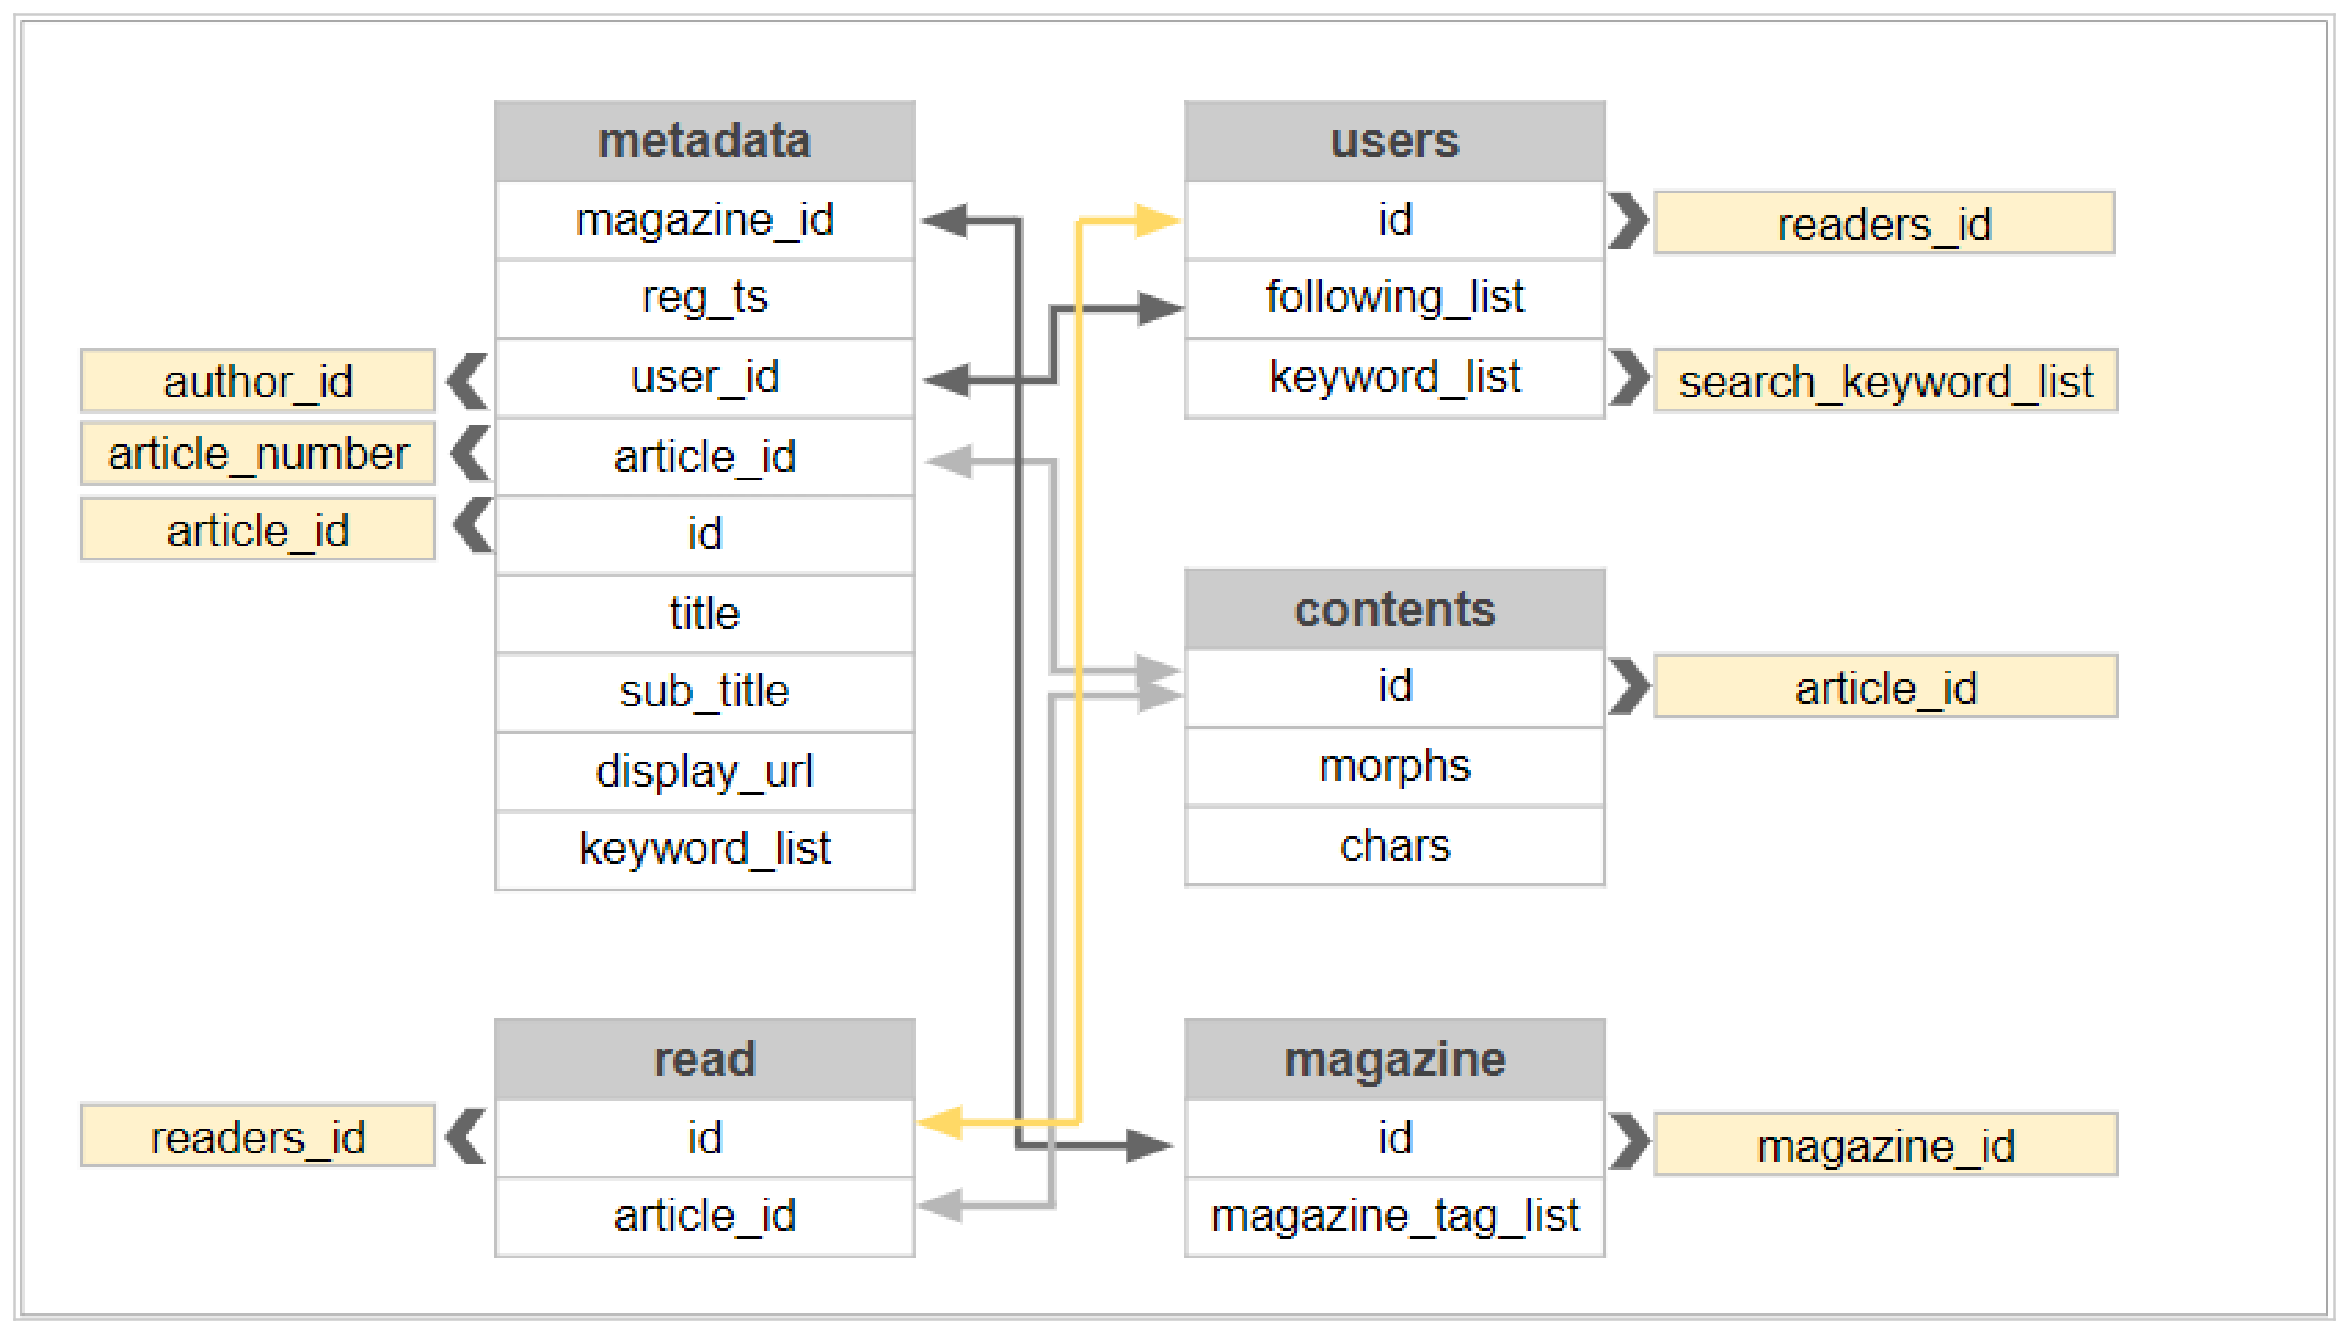

In [11]:
image = pilimg.open('brunch_data_schema.png')
pix = np.array(image)
plt.figure(figsize=(30, 12))
plt.xticks([])
plt.yticks([])
plt.grid()
plt.imshow(pix)

In [2]:
import numpy as np
import pandas as pd
import PIL.Image as pilimg
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datetime import timedelta, datetime
import missingno as msno
import glob
from itertools import chain
import json
import os
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
from numpy.polynomial.polynomial import polyfit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
sns.set_style("whitegrid")

font_location = "C:\Windows\Fonts/NanumGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc("font", family=font_name)
mpl.rcParams["font.family"]
mpl.matplotlib_fname()
plt.rcParams["figure.figsize"] = (20, 10)

# 1. Data Read & Data Preprocessing

## 1) Metadata.json
- 컬럼명 변경
    - user_id → author_id
    - id → article_id
    - article_id → article_number

In [1]:
metadata = pd.read_json('metadata.json', lines=True)

In [5]:
# metadata 컬럼명 변경
metadata.rename(columns={"user_id": "author_id",
                         "article_id": "article_number", "id": "article_id"}, inplace=True)

In [6]:
# metadata의 결측치 값 확인
metadata.isnull().values.any()

False

### a. metadata 전처리
- metadata 등록 일자 datetime으로 변환
- 매거진/개인 읽은 글 타입 지정

In [7]:
# metadata 등록 일자 datetime으로 변환
metadata["reg_datetime"] = metadata["reg_ts"].apply(lambda x: datetime.fromtimestamp(x/1000.0))
metadata["reg_dt"] = metadata["reg_datetime"].dt.date

# 매거진/개인 읽은 글 타입 지정
metadata["type"] = metadata["magazine_id"].apply(lambda x: "개인" if x == 0.0 else "매거진")

In [8]:
metadata.head()

,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,article_number,article_id,reg_datetime,reg_dt,type
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782,2016-09-27 11:47:07,2016-09-27,매거진
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81,2016-05-13 07:39:09,2016-05-13,매거진
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4,2015-11-20 14:28:07,2015-11-20,개인
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88,2017-04-01 22:59:21,2017-04-01,매거진
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34,2018-04-10 01:55:42,2018-04-10,매거진


In [9]:
metadata.shape

(643104, 12)

In [10]:
# EDA할 metadata를 copy
atc = metadata.copy()

In [11]:
atc.head(3)

,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,article_number,article_id,reg_datetime,reg_dt,type
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782,2016-09-27 11:47:07,2016-09-27,매거진
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81,2016-05-13 07:39:09,2016-05-13,매거진
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4,2015-11-20 14:28:07,2015-11-20,개인


In [12]:
# 결측지 없음
atc.isnull().values.any()

False

## 2) Magazine.json
- 컬럼명 변경
    - id → magazine_id

In [21]:
magazine = pd.read_json('magazine.json', lines=True)

In [22]:
# magazine 컬럼명 변경
magazine.rename(columns={"id": "magazine_id"}, inplace=True)

In [23]:
magazine.head()

,magazine_tag_list,magazine_id
0,"[브런치북, 육아일기, 대화법, 들려주고픈이야기]",38842
1,"[tea, food]",11540
2,[food],11541
3,"[브런치북, 일상, 시, 사람]",11546
4,"[감성에세이, 노래, 음악에세이]",11544


In [24]:
magazine.shape

(27967, 2)

In [25]:
# 결측지 없음
magazine.isnull().values.any()

False

## 3) Users.json
- 컬럼명 변경
    - id → readers_id
    - keyword_list → search_keyword_list

In [31]:
users = pd.read_json('users.json', lines=True)

In [32]:
# users 컬럼명 변경
users.rename(columns={"id": "readers_id", "keyword_list": "search_keyword_list"}, inplace=True)

In [33]:
users.head()

,search_keyword_list,following_list,readers_id
0,[],"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a
1,[],"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed
2,[],"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5
3,[],"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d
4,[],"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62


In [34]:
users.shape

(310758, 3)

In [35]:
# 결측지 없음
users.isnull().values.any()

False

## 4) Read Files
- 컬럼명 변경
    - id → readers_id

In [19]:
read_file_lst = glob.glob('C:\\Users\\Jisoo\\Desktop\\2020_Machine_Learning_Project\\read\\*')

In [20]:
# read files를 dt, hr, readers_id, article_id로 불러오기
read_df_lst = []
for file in read_file_lst:
    file_name = os.path.basename(file)
    file_df = pd.read_csv(file, header=None, names=["raw"])
    file_df["dt"] = file_name[:8]
    file_df["hr"] = file_name[8:10]
    file_df["readers_id"] = file_df["raw"].str.split(" ").str[0]
    file_df["article_id"] = file_df["raw"].str.split(" ").str[1:].str.join(" ").str.strip()
    read_df_lst.append(file_df)

In [21]:
read_df = pd.concat(read_df_lst)

In [22]:
read_df.head()

,raw,dt,hr,readers_id,article_id
0,#e208be4ffea19b1ceb5cea2e3c4dc32c @kty0613_91,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,#0a3d493f3b2318be80f391eaa00bfd1c @miamiyoung_...,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31 @banksalad_49 @rlfrjsdn_95 @rea...
2,#b90d3ee7ed0d7d827aae168e159749f1 @joeunha_4 @...,20181001,00,#b90d3ee7ed0d7d827aae168e159749f1,@joeunha_4 @yoonvi_3
3,#b8b9d09fe2961fd62edc94912bf75a90 @hyejinchoi_...,20181001,00,#b8b9d09fe2961fd62edc94912bf75a90,@hyejinchoi_122 @hyejinchoi_86 @hyejinchoi_42 ...
4,#072f742eda9359cdac03ad080193c11d @doyeonsunim...,20181001,00,#072f742eda9359cdac03ad080193c11d,@doyeonsunim_240 @k52524_297 @bule13_33 @kwong...


### a. read_df 전처리
- article_id의 list 형태로 된 values 나누기

In [23]:
# 한 readers_id별 읽은 글 수 세기 (readers_id별 article_id의 list안의 values 개수 세기)
read_count = read_df["article_id"].str.split(" ").map(len)

In [24]:
# read_count 중심으로 readers_id별 article_id 하나씩 나눈 DataFrame 만들기
# dt, hr : 글 읽은 시간
read = pd.DataFrame({"dt": np.repeat(read_df["dt"], read_count),
                     "hr": np.repeat(read_df["hr"], read_count),
                     "readers_id": np.repeat(read_df["readers_id"], read_count),
                     "article_id": list(chain.from_iterable(read_df["article_id"].str.split(" ")))})

In [25]:
read.head()

,dt,hr,readers_id,article_id
0,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@rlfrjsdn_95
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@readme999_140


In [26]:
print("전체 read 데이터 건수:", read.shape)
print("중복 소비를 제외한 데이터 건수:", read[['readers_id', 'article_id']].drop_duplicates().shape)
print("Unique 독자 수:", len(read['readers_id'].unique()))
print("소비된 Unique 글 수:", len(read['article_id'].unique()))
print("#으로 시작되는 article_id 수: ", len(read[read.article_id.str.contains("#")]))

전체 read 데이터 건수: (22110706, 4)
중복 소비를 제외한 데이터 건수: (12597878, 2)
Unique 독자 수: 306222
소비된 Unique 글 수: 505841
#으로 시작되는 article_id 수:  92767


In [27]:
# 결측지 없음
read.isnull().values.any()

False

# 2. EDA
소비자 성향에 맞춰 글을 추천을 하기 위해서는 작가, 독자로 나누어 살펴봄. 그 후 시간에 따른 글의 변화량, 글 소비 패턴, 소비자들의 경향(신규/단골), 월별 평균 읽힌 글 수 등의 파악이 필요하다 생각. 또한, Brunch에서 제공한 메거진 플랫폼을 살펴봄.
<br>

---
*EDA table of contents*
1. 작가
    - 등록일자별 글 수
2. 독자
    - 글 소비
        - 글별 소비수 통계
        - 등록일자별 글 소비수
        - 경과일에 따른 글 소비 변화
    - 유저
        - 방문일수 기준 유저 통계
        - 신규/단골 그룹내 인기 글
        - Following List 통계
    - 독자의 월별 및 평균 글 소비 수 Describe
    - 독자별 글 소비수에 따른 그룹 구분
3. Magazine
    - 전체 글에서 메거진 등록 글 비중
    - 유저별 소비된 글에서 메거진 등록 글 비중
    - 메거진 이용하는 작가 수

## 1) 작가

### a. 등록일자별 글 수

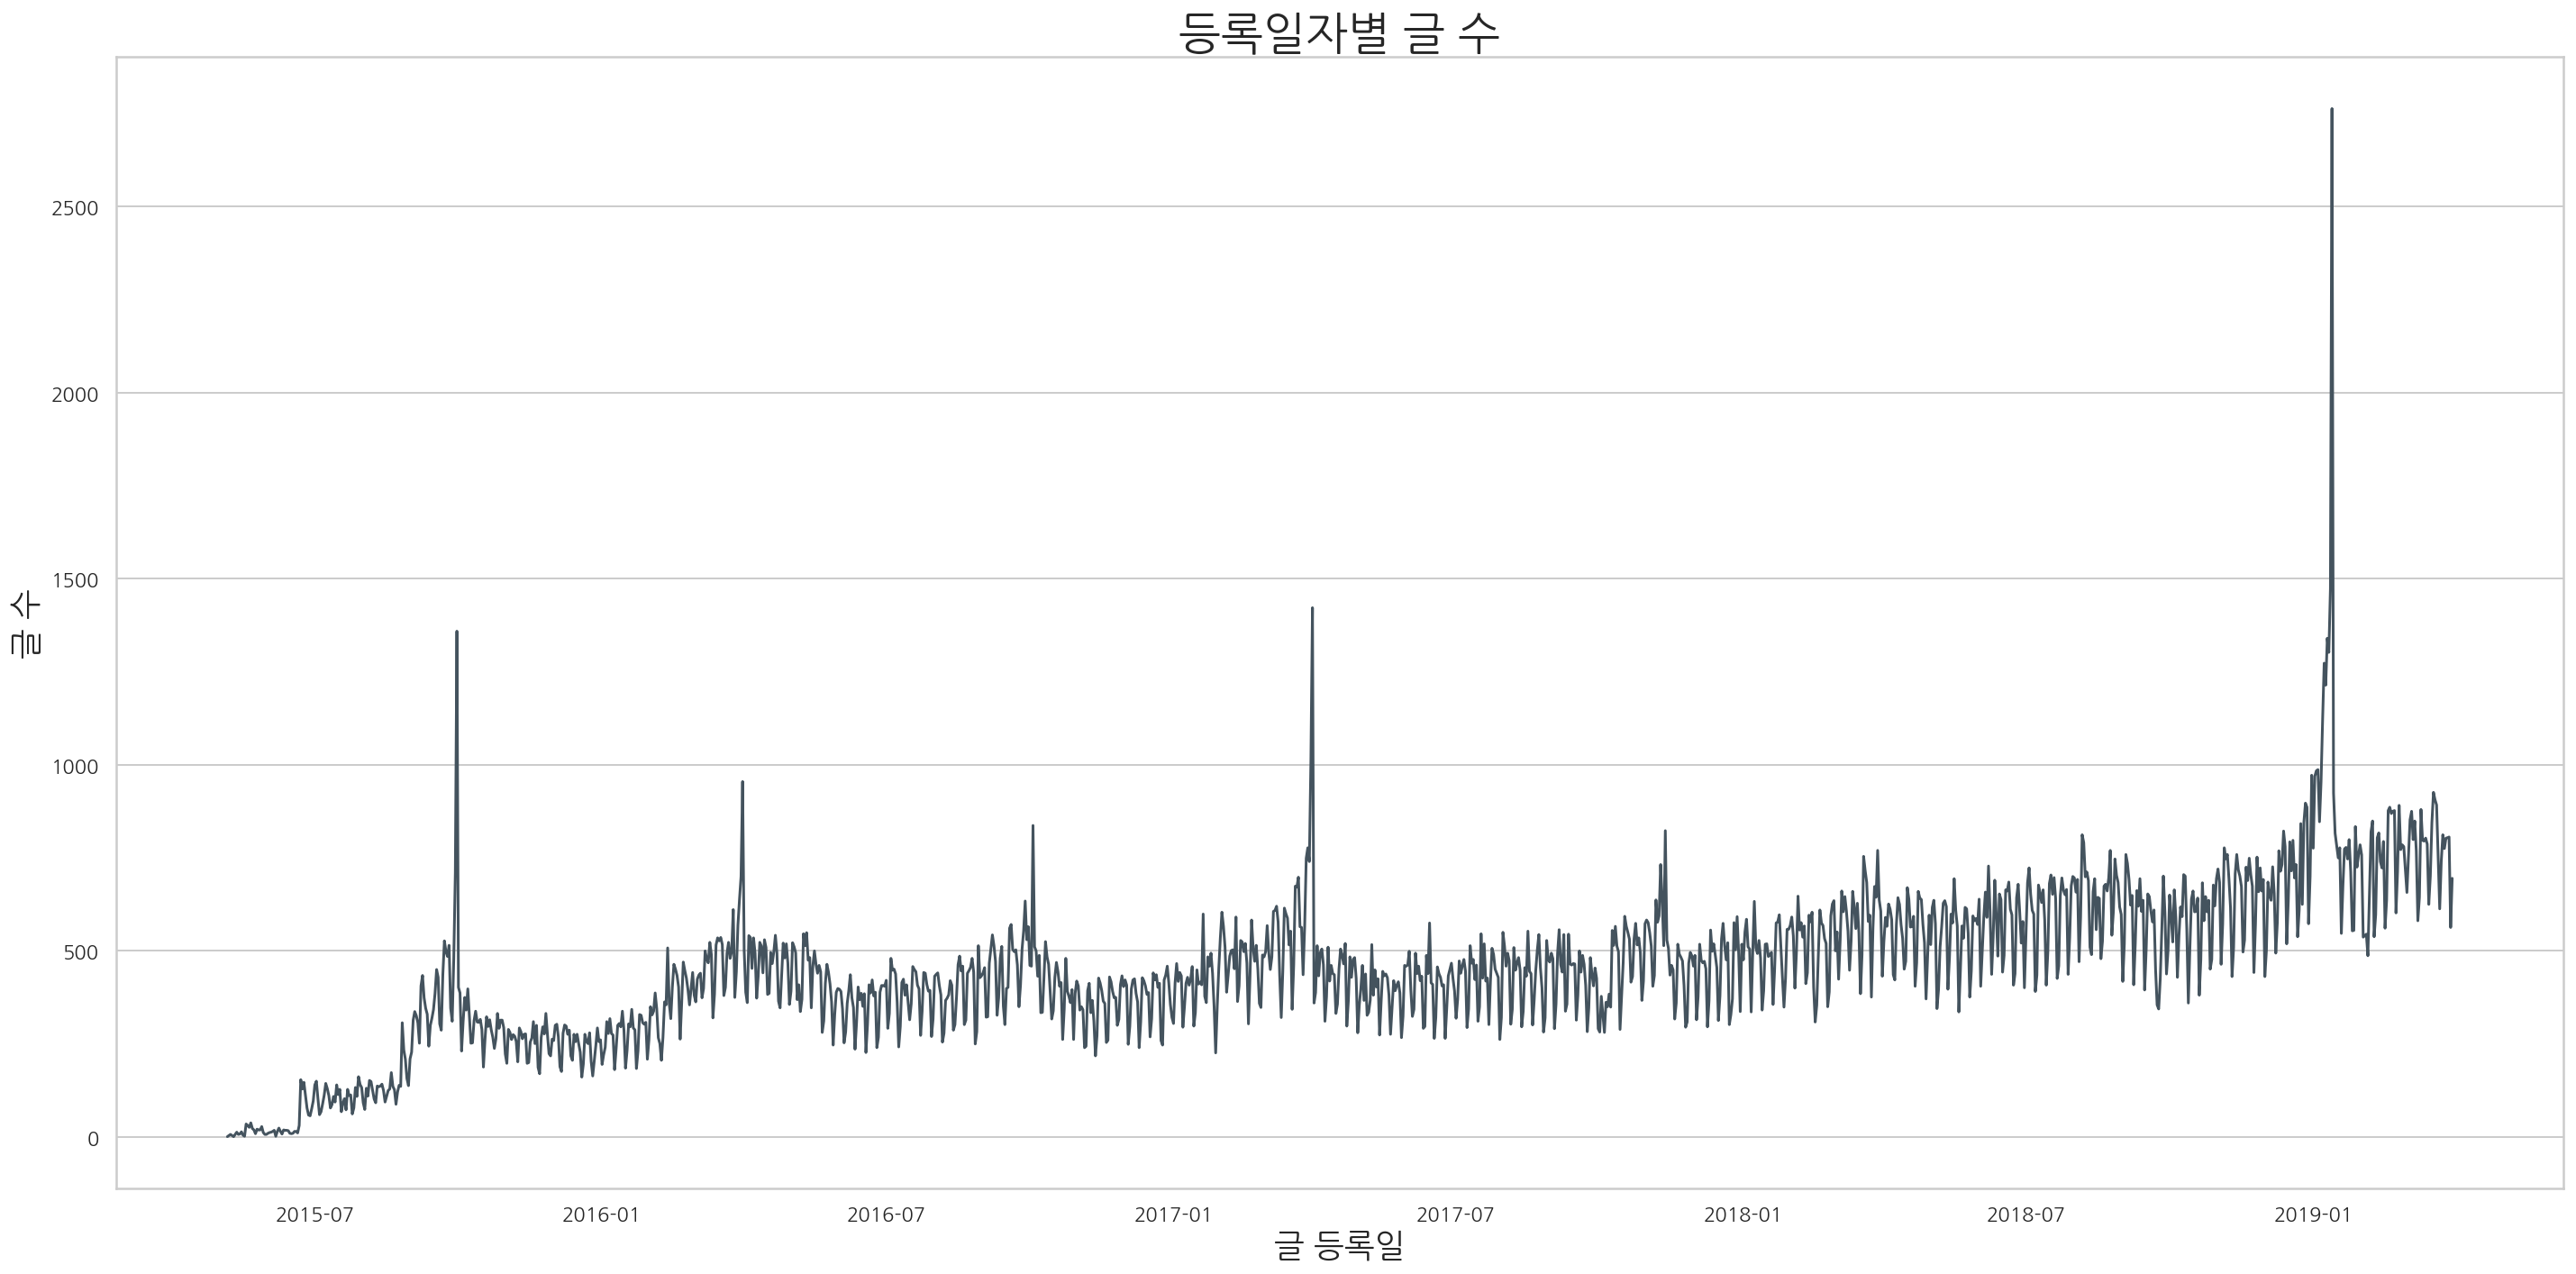

In [40]:
sns.lineplot(data=atc.groupby("reg_dt", as_index=False)["article_id"].count()[
             1:], x="reg_dt", y="article_id", color="#44535e")
plt.title("등록일자별 글 수", fontsize=25)
plt.xlabel("글 등록일", fontsize=18)
plt.ylabel("글 수", fontsize=18)
plt.grid(axis="x")

plt.savefig("Brunch_등록일자별_글_수.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

- 일자가 최신일수록 등록된 글의 수가 많음 (brunch에서 점차 등록되는 글이 증가한다.)

## 2) 독자

### a. 글 소비
1. 총 글별 소비수 통계
    - metadata를 찾을 수 없는 로그를 제외한 후 글별 소비수 통계
        - #으로 시작하는 article_id인 글 제외하고 글별 소비를 분석 [#으로 시작하는 article_id는 metadata 정보 없음]
2. 등록일자별 글 소비수
3. 경과일에 따른 글 소비 변화

#### 가. 총 글별 소비수 통계

In [41]:
# 읽은 정보가 없는 readers_id 제외하고 글별 소비 수 DataFrame 생성
atc_read_cnt = read[read.article_id != ""].groupby("article_id", as_index=False)["readers_id"].count()
atc_read_cnt.rename(columns={"readers_id": "read_cnt"}, inplace=True)

In [42]:
atc_read_cnt.head()

,article_id,read_cnt
0,#00700c454af49d5c9a36a13fcba01d0a_1,112
1,#00700c454af49d5c9a36a13fcba01d0a_10,24
2,#00700c454af49d5c9a36a13fcba01d0a_100,37
3,#00700c454af49d5c9a36a13fcba01d0a_101,32
4,#00700c454af49d5c9a36a13fcba01d0a_102,40


In [43]:
# 결측치 없음
atc_read_cnt.isnull().values.any()

False

In [44]:
# 총 글별 소비수 통계
atc_read_cnt.describe()

,read_cnt
count,505840.000000
mean,43.700988
std,302.292764
min,1.000000
25%,3.000000
50%,8.000000
75%,25.000000
max,97206.000000


In [45]:
# 제일 많이 읽힌 article_id 확인
atc_read_cnt[atc_read_cnt.read_cnt == 97206]

,article_id,read_cnt
63061,@brunch_141,97206


- 글 한개당 최대는 97206회(@brunch_141글) 소비를 함
- 글 한개당 소비수의 최소는 1회
- 글 한개당 소비수의 평균은 43.7회

##### metadata를 찾을 수 없는 로그를 제외한 후 글별 소비수 통계
- #으로 시작하는 article_id인 글 제외하고 글별 소비를 분석

In [46]:
# metadata 결합 (#포함 article_id의 metadata 정보 확인을 위해서)
atc_read_cnt_meta = pd.merge(atc_read_cnt, atc, how="left", left_on="article_id", right_on="article_id")

In [47]:
atc_read_cnt_meta.isnull().values.any()

True

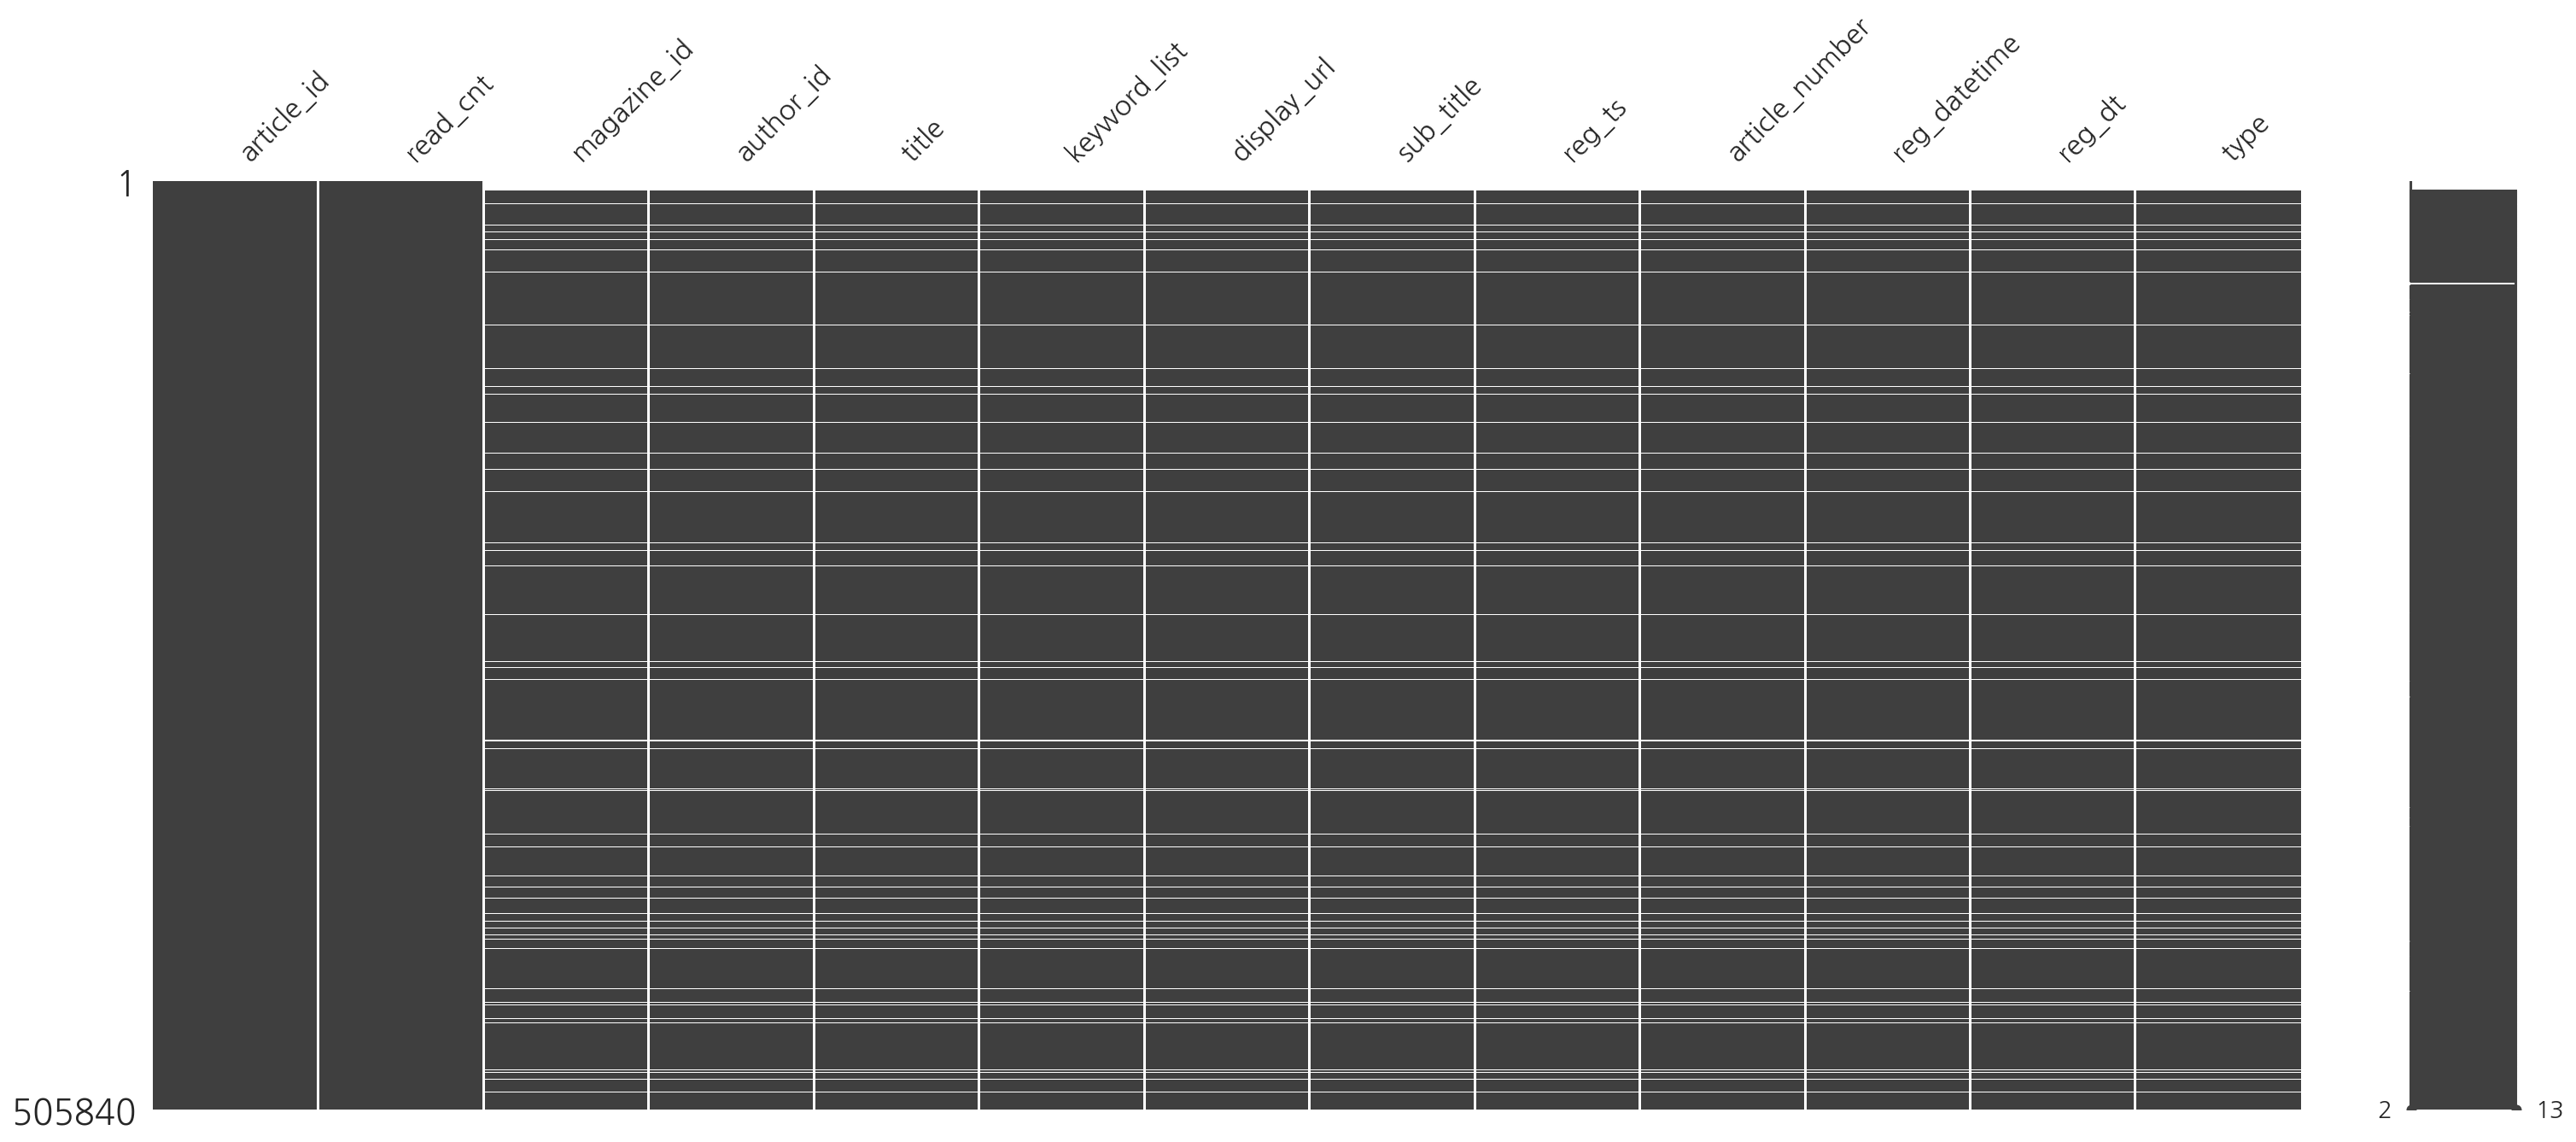

In [48]:
msno.matrix(atc_read_cnt_meta)
plt.show()

---
atc_read_cnt(read 데이터)에는 #으로 시작하는 article_id가 존재 <br>
하지만 metadata에는 #으로 시작하는 article_id 정보가 없음 (#으로 시작하는 article_id는 비식별화 같음. [추측]) <br>
따라서 metadata를 act_read_cnt데이터 중심으로 merge한 act_read_cnt_meta 데이터에서는 결측치가 존재한다. <br>
(#으로 시작하는 article_id의 metadata에 대한 데이터 결측치)

In [49]:
atc_read_cnt_meta.tail(2)

,article_id,read_cnt,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,article_number,reg_datetime,reg_dt,type
505838,@zzzaam_9,43,0.0,@zzzaam,디자인팀에 작가가 필요한 이유,"[UX, 작가, 글쓰기]",https://brunch.co.kr/@zzzaam/9,Writers + Designers = A match made in he,1.496501e+12,9.0,2017-06-03 23:39:22,2017-06-03,개인
505839,@zzzwhite_4,2,0.0,@zzzwhite,너는 희망이다.,"[감성그림, 희망, 엄마]",https://brunch.co.kr/@zzzwhite/4,감성드로잉,1.467290e+12,4.0,2016-06-30 21:30:54,2016-06-30,개인


In [50]:
# metadata를 찾을 수 없는 소비 로그 제외 (#으로 시작하는 article_id 제거)
atc_read_cnt_nn = atc_read_cnt_meta[atc_read_cnt_meta["article_number"].notnull()]

In [51]:
# metadata를 찾을 수 없는 로그를 제외한 후 글별 소비수 통계
atc_read_cnt_nn["read_cnt"].describe()

count    476147.000000
mean         43.904592
std         304.873256
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max       97206.000000
Name: read_cnt, dtype: float64

- 글 한개당 최대는 97206회(@brunch_141글) 소비를 함
- 글 한개당 소비수의 최소는 1회
- 글 한개당 소비수의 평균은 43.9회
<br>
---
총 글별 소비수와 차이점이 크지 않다.

#### 나. 등록일자별 글 소비수
- 위에서 확인한 글별 소비수 통계를 바탕으로 등록일자별 글 소비수 경향을 확인해보자.
(metadata를 찾을 수 없는 로그를 제외한 글별 소비수)

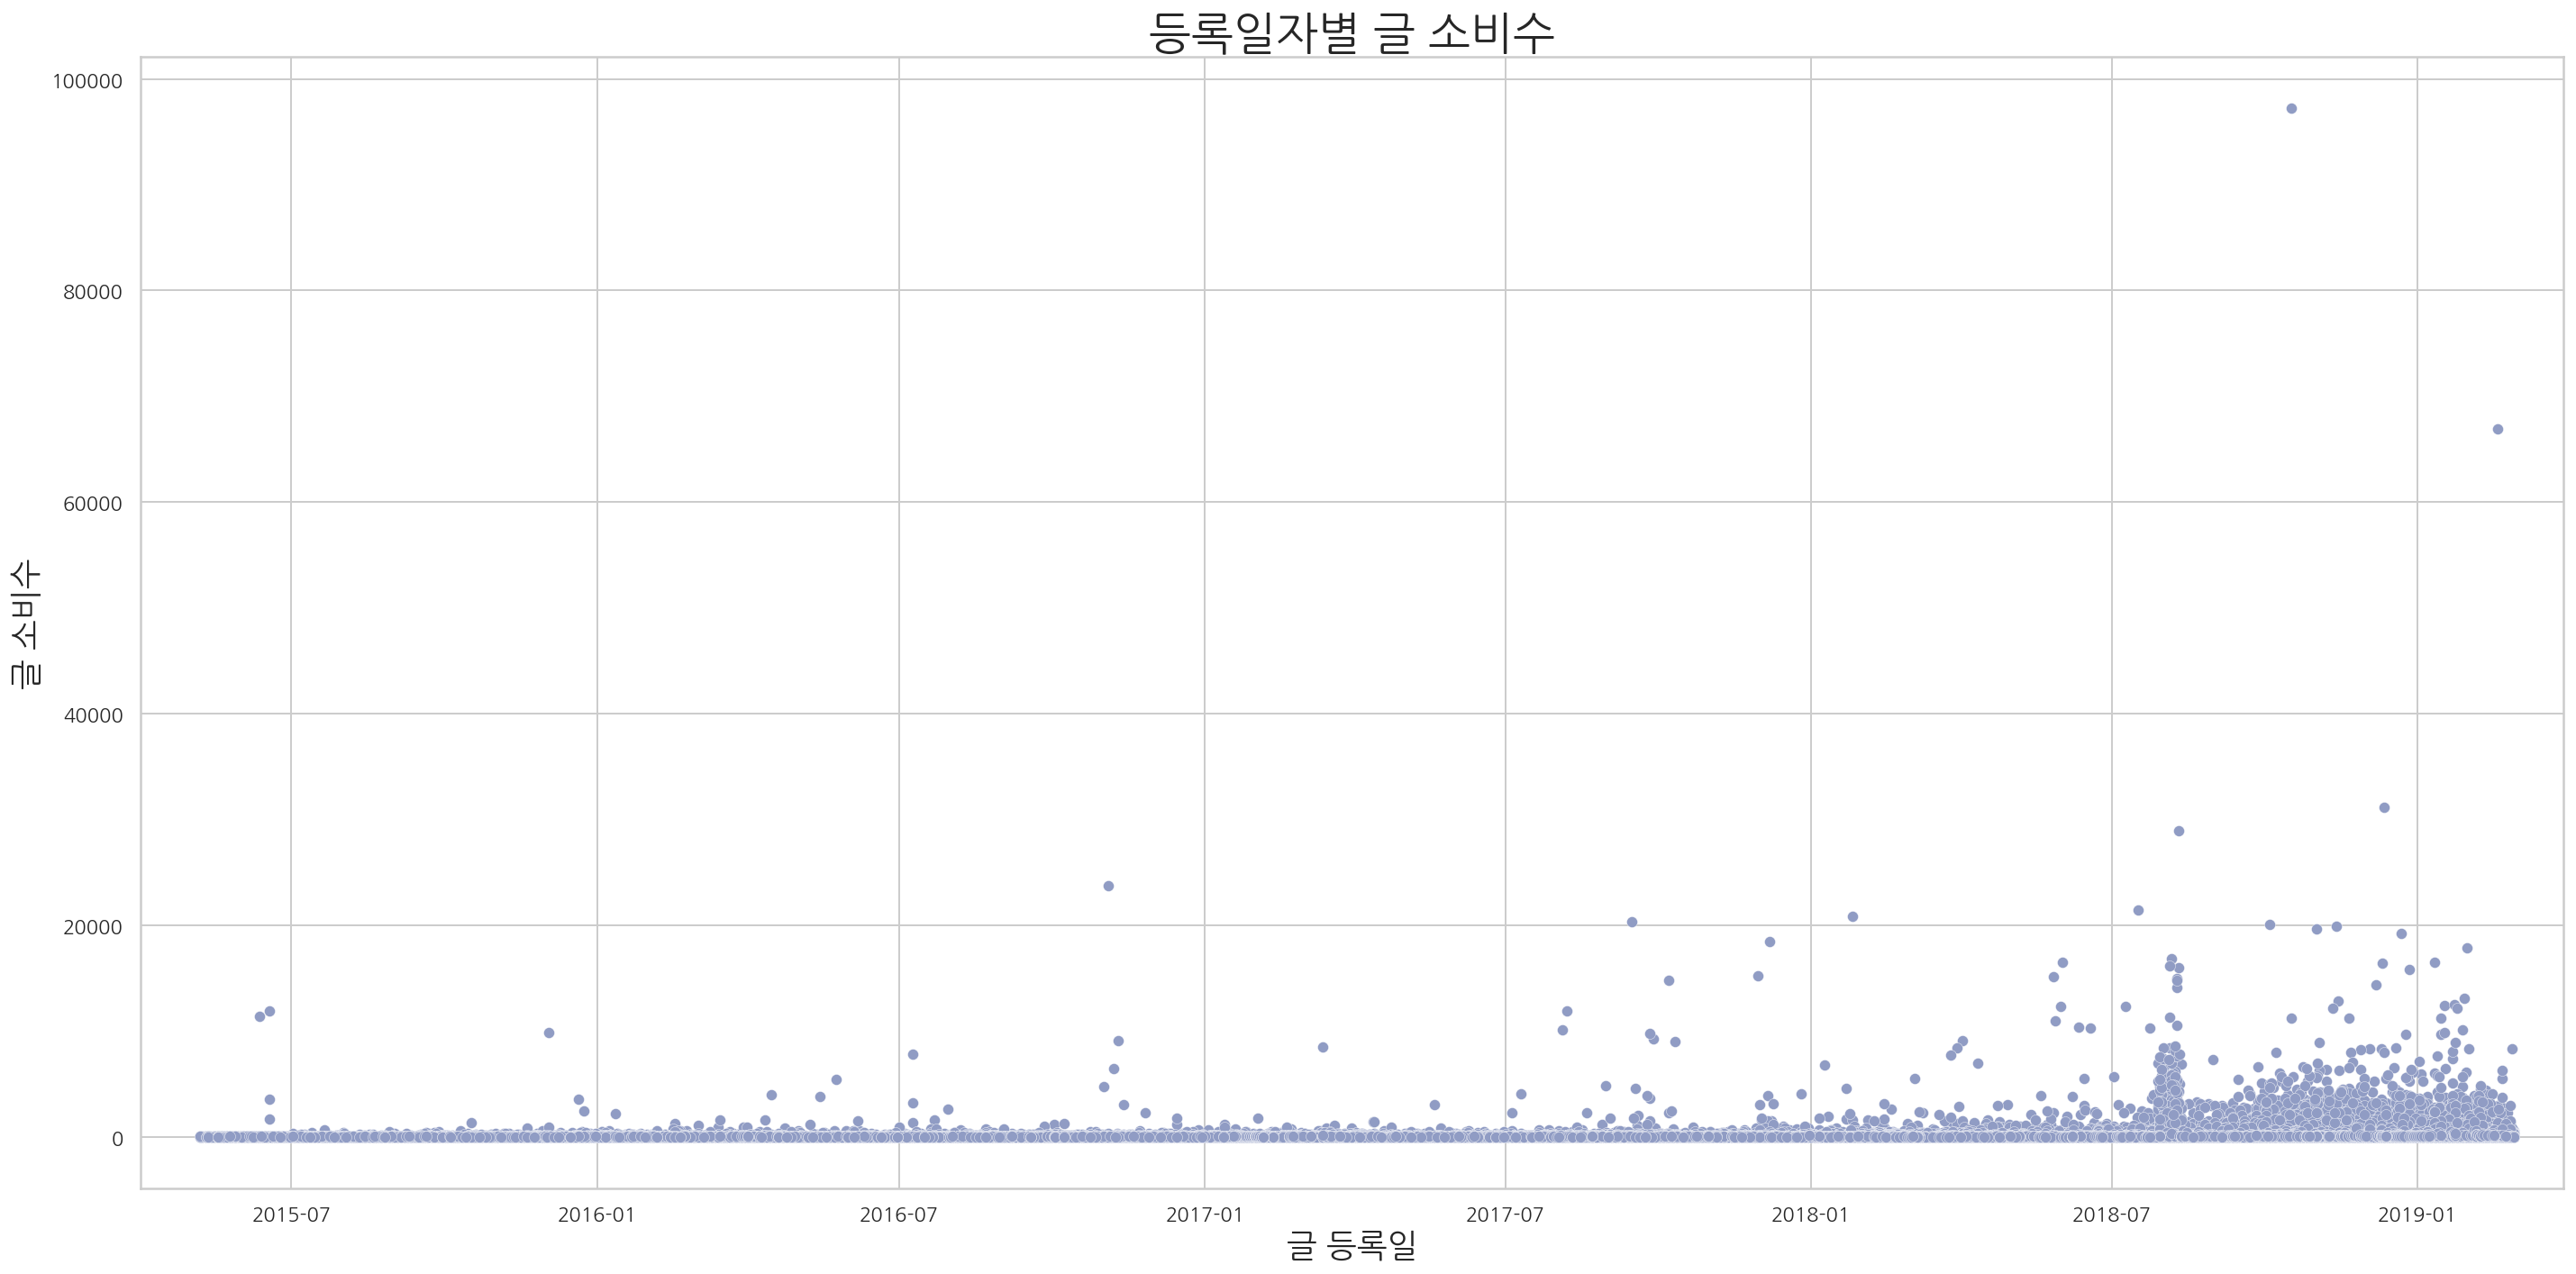

In [52]:
plt.scatter(x=atc_read_cnt_nn["reg_dt"], y=atc_read_cnt_nn["read_cnt"],
            c="#909cc4", edgecolors="w", linewidth=0.2)
plt.xlim(datetime.date(datetime(2015, 4, 1)),
         datetime.date(datetime(2019, 3, 30)))
plt.title("등록일자별 글 소비수", fontsize=25)
plt.xlabel("글 등록일", fontsize=18)
plt.ylabel("글 소비수", fontsize=18)

plt.savefig("Brunch_등록일자별_글_소비수.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

- 두 개의 아티클이 글 소비수가 매우 높음 (우측 상단, 60000 이상)
- 그래프를 자세히 보기 위해 두 개의 아티클을 제외하고 다시 그려보자

In [53]:
# 글 소비수가 가장 높은 article_id 2개 확인
atc_read_cnt_nn.sort_values(by="read_cnt", ascending=False).head(2)

,article_id,read_cnt,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,article_number,reg_datetime,reg_dt,type
63061,@brunch_141,97206,0.0,@brunch,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,"[브런치X빨강머리앤, 빨강머리앤, 출판, 작가]",https://brunch.co.kr/@brunch/141,글·그림 작가 파트너 프로젝트,1.539742e+12,141.0,2018-10-17 11:11:22,2018-10-17,개인
63070,@brunch_151,66903,0.0,@brunch,"브런치 무비 패스, 영화의 진한 여운을 나누세요","[브런치, 시사회, 브런치무비패스]",https://brunch.co.kr/@brunch/151,브런치 무비 패스 5기 작가 모집,1.550466e+12,151.0,2019-02-18 14:00:34,2019-02-18,개인


In [54]:
# 글 소비수가 가장 높은 두 개의 article_id 제외
atc_read_cnt_nn_2 = atc_read_cnt_nn.sort_values(by="read_cnt", ascending=False)[2:]

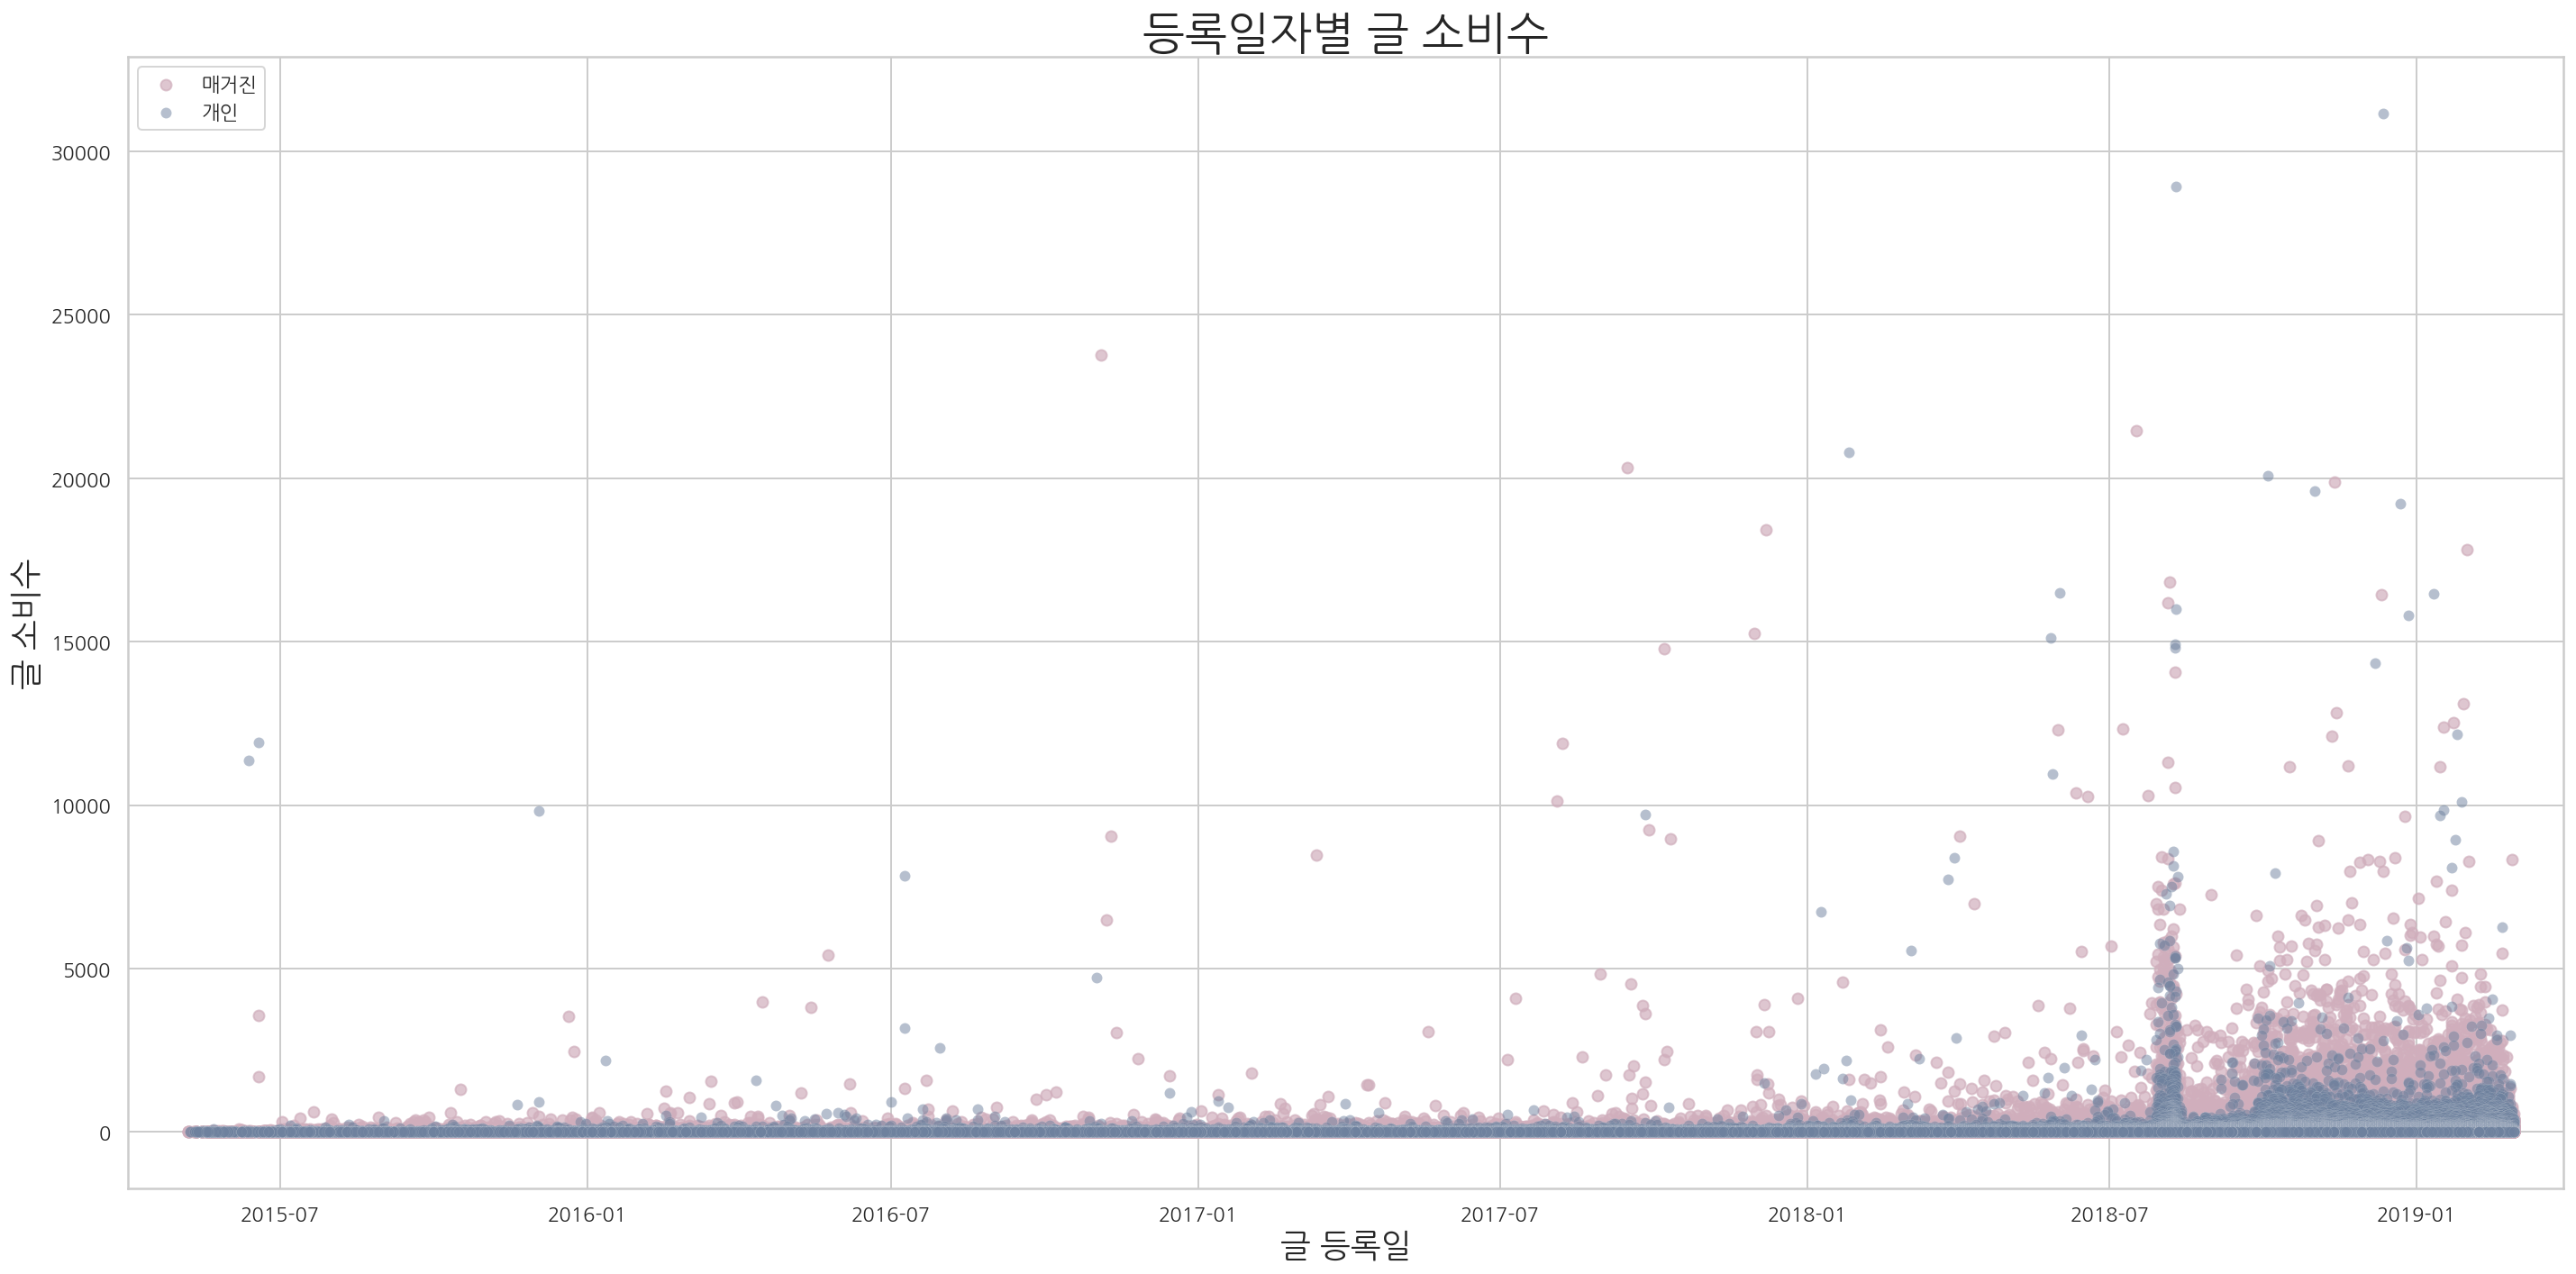

In [55]:
plt.scatter(x=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "매거진"]["reg_dt"],
            y=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "매거진"]["read_cnt"], c="#d0aebc", alpha=0.7)
plt.scatter(x=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "개인"]["reg_dt"], y=atc_read_cnt_nn_2[atc_read_cnt_nn_2.type == "개인"]["read_cnt"],
            c="#6e819e", linewidth=0.08, alpha=0.5, edgecolors="w")
plt.xlim(datetime.date(datetime(2015, 4, 1)),
         datetime.date(datetime(2019, 3, 30)))
plt.title("등록일자별 글 소비수", fontsize=25)
plt.xlabel("글 등록일", fontsize=18)
plt.ylabel("글 소비수", fontsize=18)
plt.legend(["매거진", "개인"], loc="upper left")

plt.savefig("Brunch_등록일자별_글_소비수[아웃라인제거].png", bbox_inches="tight")
plt.tight_layout()
plt.show()

- 독보적으로 글의 소비수가 많은 두개의 글을 제외하고 본 결과 등록일자가 최신일수록 글의 소비수가 많으며 매거진이 개인이 쓴 글보다 이러한 현상이 더 뚜렷히 나타남

#### 다. 경과일에 따른 글 소비 변화
- 2018.10.01 이후 등록된 글 기준

##### 경과일에 따른 글 소비 Data 생성

In [56]:
# 경과일을 알기 위해 [글 읽힌 날짜 - 글 등록 날짜]를 확인
# 그러기 위해 read data와 atc data(metadata) merge
off_data = pd.merge(read, atc, how="inner", left_on="article_id", right_on="article_id")

In [57]:
off_data.shape

(20905040, 15)

In [58]:
# off_data 컬럼 정리
off_data.rename(columns={"dt": "read_dt"}, inplace=True)
off_data = off_data[["read_dt", "reg_dt", "readers_id", "article_id", "author_id",
                     "title", "sub_title", "type", "display_url", "keyword_list", "magazine_id"]]

In [59]:
off_data.head(3)

,read_dt,reg_dt,readers_id,article_id,author_id,title,sub_title,type,display_url,keyword_list,magazine_id
0,20181001,2018-10-01,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91,@kty0613,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720
1,20181001,2018-10-01,#e6097910257c8b79380da50b4bce705b,@kty0613_91,@kty0613,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720
2,20181001,2018-10-01,#abfa7b43a9c3f4894ca450b0436fcd38,@kty0613_91,@kty0613,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720


In [60]:
# [글 읽힌 날짜 - 글 등록 날짜] 경과일을 알기 위해 datetime으로 변경
off_data["read_dt"] = pd.to_datetime(off_data["read_dt"], format="%Y%m%d")
off_data["reg_dt"] = pd.to_datetime(off_data["reg_dt"], format="%Y-%m-%d")

# 경과일 구하기
off_data["off_day"] = (off_data["read_dt"] - off_data["reg_dt"]).dt.days

In [61]:
# 글별 소비수 count DataFrame 인 atc_read_cnt_nn과 결합 (경과일에 따른 글별 소비수를 파악하기 위해)
off_data = pd.merge(off_data, atc_read_cnt_nn[["article_id", "read_cnt"]], 
                    how="left", left_on="article_id", right_on="article_id")

In [62]:
off_data.shape

(20905040, 13)

In [63]:
off_data.head(3)

,read_dt,reg_dt,readers_id,article_id,author_id,title,sub_title,type,display_url,keyword_list,magazine_id,off_day,read_cnt
0,2018-10-01,2018-10-01,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91,@kty0613,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298
1,2018-10-01,2018-10-01,#e6097910257c8b79380da50b4bce705b,@kty0613_91,@kty0613,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298
2,2018-10-01,2018-10-01,#abfa7b43a9c3f4894ca450b0436fcd38,@kty0613_91,@kty0613,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298


In [64]:
# 경과일에 따른 글 소비 변화를 파악하고자 글별 경과일, read_dt, reg_dt 등이 같은거를 중심으로 readers_id의 수를 세기
off_data_count = off_data.groupby(["article_id", "off_day", "read_dt", "reg_dt", "title", "author_id",
                                   "type", "display_url", "magazine_id"], as_index=False)["readers_id"].count()

In [65]:
# 등록일자가 1970-01-01로 된 로그들 (등록일자 누락으로 추정)
off_data_count[off_data_count.reg_dt == "1970-01-01 00:00:00"].head(3)

,article_id,off_day,read_dt,reg_dt,title,author_id,type,display_url,magazine_id,readers_id
166,@01023920600_18,17870,2018-12-05,1970-01-01,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,2
167,@01023920600_18,17891,2018-12-26,1970-01-01,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,2
168,@01023920600_18,17914,2019-01-18,1970-01-01,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,1


##### 분석

In [66]:
# 경과일자별 소비수 총합
off_day_sum = off_data_count[(off_data_count["reg_dt"] >= datetime(2018, 10, 1)) & (
    off_data_count.off_day >= 0)].groupby("off_day")["readers_id"].sum()

In [67]:
# 경과일자에 등록되어있는 아티클 수
reg_dt_cnt = off_data_count[(off_data_count['reg_dt'] >= datetime(2018, 10, 1)) & (
    off_data_count.off_day >= 0)].groupby('reg_dt')['article_id'].nunique()

In [68]:
# reg_dt_cnt.cumsum()을 해서 일자가 경과함에 따라 등록된 article_id(글) 수 누적시킨다.
# 최종적으로 겅과일자별에따른 소비수 총합, 등록 일, 아티클 수 DataFrame 생성 (index가 경과일)
off_day_avg = pd.concat([off_day_sum, reg_dt_cnt.cumsum().sort_index(ascending=False).reset_index()], axis=1)

In [69]:
off_day_avg.rename(columns={"readers_id": "readers_cnt", "article_id": "article_cnt"}, inplace=True)
off_day_avg # index가 경과일

,readers_cnt,reg_dt,article_cnt
0,3142049,2019-02-28,107356
1,1726882,2019-02-27,106649
2,1017862,2019-02-26,105891
3,776093,2019-02-25,105156
4,632960,2019-02-24,104308
...,...,...,...
146,432,2018-10-05,3013
147,428,2018-10-04,2424
148,262,2018-10-03,1762
149,154,2018-10-02,1239


- 2019-02-28 글 등록하고 경과일 0일 됐을 때 까지 소비수(readesr_id) 3142049명
- 2018-10-01 글 등록하고 경과일 150일 됐을 때(2019-02-28까지) 까지 소비수 (readers_id) 67명 

In [70]:
# 경과일에 따른 글 소비 변화 평균
off_day_avg["off_avg"] = off_day_avg["readers_cnt"] / off_day_avg["article_cnt"]

In [71]:
off_day_avg.head(10)

,readers_cnt,reg_dt,article_cnt,off_avg
0,3142049,2019-02-28,107356,29.267568
1,1726882,2019-02-27,106649,16.192201
2,1017862,2019-02-26,105891,9.612356
3,776093,2019-02-25,105156,7.380397
4,632960,2019-02-24,104308,6.068183
5,529081,2019-02-23,103611,5.106417
6,436611,2019-02-22,103019,4.238160
7,412530,2019-02-21,102167,4.037801
8,236772,2019-02-20,101343,2.336343
9,193039,2019-02-19,100511,1.920576


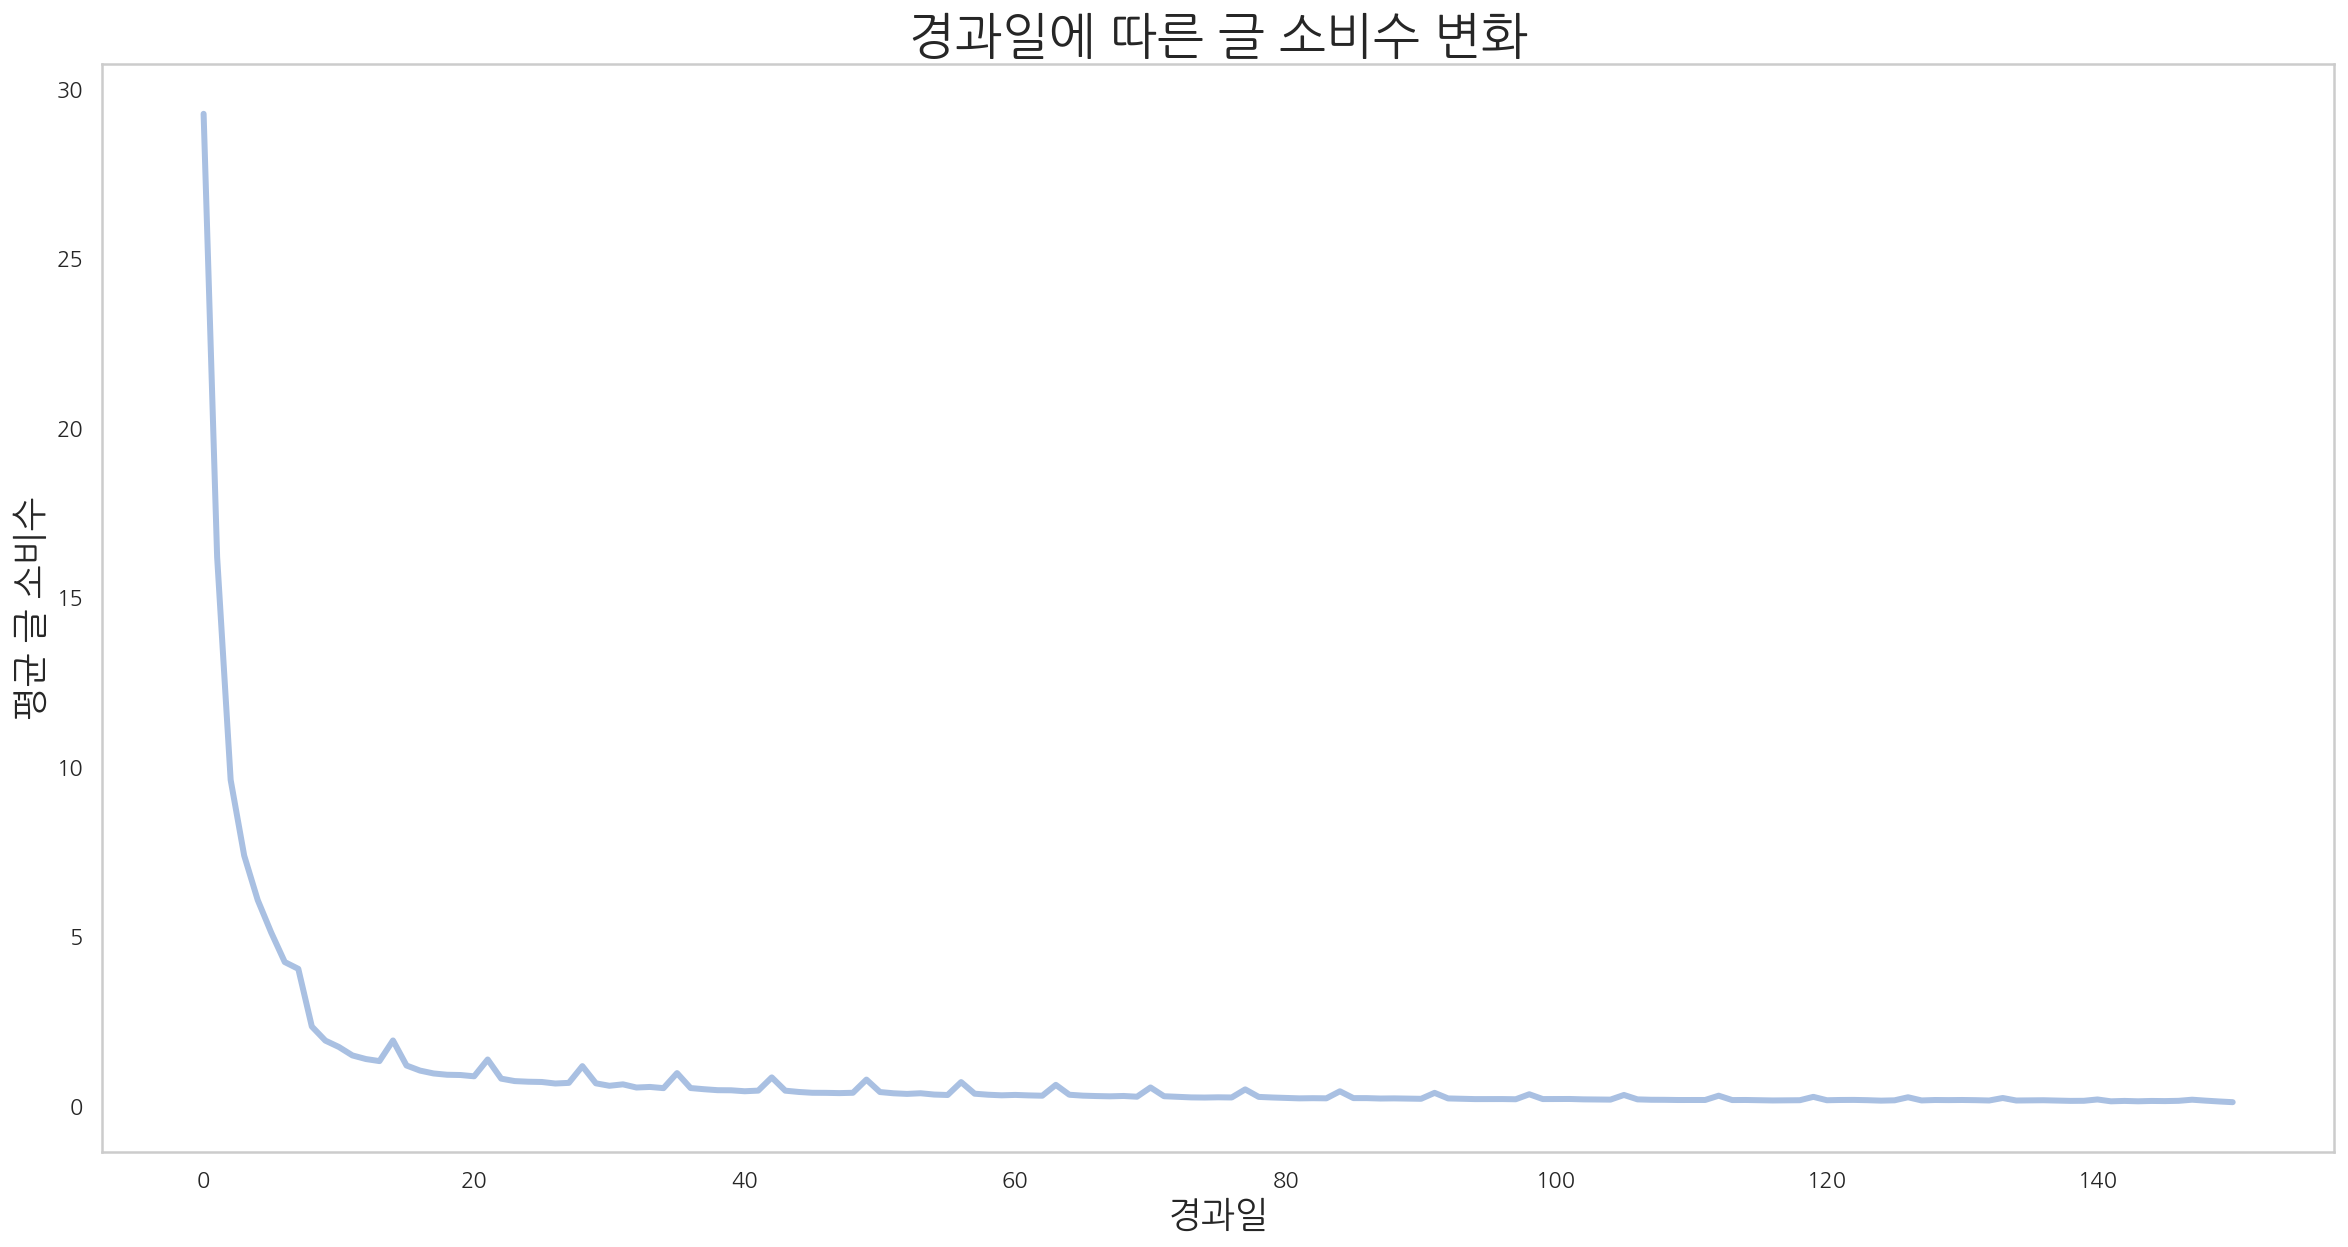

In [72]:
plt.plot(off_day_avg.index,
         off_day_avg["off_avg"], color="#a9c0e2", linestyle="-", linewidth=3.0)
plt.title("경과일에 따른 글 소비수 변화", fontsize=25)
plt.xlabel("경과일", fontsize=18)
plt.ylabel("평균 글 소비수", fontsize=18)
plt.grid(False)

plt.savefig("경과일에 따른 글 소비수 변화.png", bbox_inches="tight")
plt.show()

- 글의 등록일이 경과할 수록 글 소비수는 줄어들음. 즉, 글 등록시 소비량이 가장 많다.

### b. 유저
- 독자의 글 소비하는 경향 및 신규/단골의 특징을 분석

In [73]:
# 유저별 방문일수, 글 소비수
grp_by_user = off_data.groupby("readers_id").agg({"read_dt": ["nunique", "count"]}).reset_index()
grp_by_user.columns = ["readers_id", "visit_day_cnt", "read_cnt"]

In [74]:
grp_by_user.head()

,readers_id,visit_day_cnt,read_cnt
0,#00001ba6ca8d87d2fc34d626ba9cfe6f,1,3
1,#0000e87158c1426d6ffb72cebac6cb64,1,2
2,#0000eea6d339abfd02ed590bc451fc63,1,1
3,#0000fdba8f35c76eacab74c5c6bc7f1a,3,11
4,#000127ad0f1981cae1292efdb228f0e9,1,27


#### 가. 방문일수 기준 유저 통계

In [75]:
# visit_day_cnt를 유일값 별 상대적 비율을 확인 (방문 일수별 percentage)
# index가 방문일 수
grp_by_user["visit_day_cnt"].value_counts(normalize=True)

1      0.352137
2      0.142516
3      0.088841
4      0.063050
5      0.047217
         ...   
134    0.000033
143    0.000030
145    0.000026
149    0.000023
150    0.000020
Name: visit_day_cnt, Length: 151, dtype: float64

In [76]:
# 방문횟수 75회 이상 유저들의 percentage 알아보기
grp_by_user["visit_day_cnt"].value_counts(normalize=True).sort_index()[74:].sum()

0.009034902176890052

- 1~2회 방문 유저 전체 유저중 50%
- 75회 이상 방문하는유저 전체 유저중 약 1%
- 1~2일 방문유저를 신규유저 / 75일(2018.10.01-2019.02.28 총 150일 기간의 절반 방문) 방문 유저를 단골유저로 구분

In [77]:
# 신규 유저
low_visit_user = grp_by_user.loc[grp_by_user["visit_day_cnt"] <= 2, "readers_id"]

In [78]:
# 단골 유저
upp_visit_user = grp_by_user.loc[grp_by_user["visit_day_cnt"] >= 75, "readers_id"]

In [79]:
# 신규 유저, 단골 유저의 글 소비수를 알아보기 위해 off_date(경과일, 글소비수 등이 있는 dataframe)을 활용
off_data_low = off_data[off_data.readers_id.isin(low_visit_user)]
off_data_upp = off_data[off_data.readers_id.isin(upp_visit_user)]

In [80]:
# 전체 유저 글 소비수, 신규 유저 글 소비수, 단골 유저 글 소비수
off_data.shape, off_data_low.shape, off_data_upp.shape

((20905040, 13), (1083925, 13), (5002114, 13))

In [81]:
# 신규, 단골 유저의 글 소비수 percentage
# (신규 유저 글 소비수/전체 유저 글 소비수), (단골 유저 글 소비수/전체 유저 글 소비수)
off_data_low.shape[0]/off_data.shape[0]*100, off_data_upp.shape[0]/off_data.shape[0]*100

(5.18499366659906, 23.92778966220586)

- 신규 유저의 글 소비는 전체의 5%, 단골 유저의 글 소비는 전체의 24%

In [82]:
# 신규 유저 평균 글 소비수, 표준편차
off_data_low.groupby("readers_id")["article_id"].count().mean(), off_data_low.groupby("readers_id")["article_id"].count().std()

(7.230842611555473, 13.573547204837958)

In [83]:
# 단골 유저 평균 글 소비수, 표준편차
off_data_upp.groupby("readers_id")["article_id"].count().mean(), off_data_upp.groupby("readers_id")["article_id"].count().std()

(1826.9225712198686, 2758.1071094196964)

- 신규 유저의 평균 글 소비수는 7, 표준편차 14
- 단골 유저의 평균 글 소비수는 1827, 표준편차 2758

#### 나. 신규/단골 그룹내 인기 글

In [84]:
# 신규 유저가 읽은 글들의 인기 글 분석 (소비수가 높은 글부터 sorting해서 ranking 쓰기)
off_data_low_rk = off_data_low.groupby(["article_id", "title", "reg_dt"])["readers_id"].count().sort_values(ascending=False)
off_data_low_rk = off_data_low_rk.reset_index()
off_data_low_rk["rank"] = off_data_low_rk.index + 1

In [85]:
# 단골 유저가 읽은 글들의 인기 글 분석 (소비수가 높은 글부터 sorting해서 ranking 쓰기)
off_data_upp_rk = off_data_upp.groupby(["article_id", "title", "reg_dt"])["readers_id"].count().sort_values(ascending=False)
off_data_upp_rk = off_data_upp_rk.reset_index()
off_data_upp_rk["rank"] = off_data_upp_rk.index + 1

In [86]:
# 신규 독자 소비수 상위 상위 10개 글
off_data_low_rk.head(10)

,article_id,title,reg_dt,readers_id,rank
0,@brunch_141,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,13519,1
1,@brunch_151,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,8160,2
2,@brunch_1,"글이 작품이 되는 공간, 브런치",2015-06-12,5282,3
3,@brunch_140,카카오 크리에이터스 스튜디오에서 브런치 작가를 만나다.,2018-10-04,4343,4
4,@brunch_2,브런치 작가 신청 안내,2015-06-18,4068,5
5,@brunch_145,"10인의 에디터와 함께 하는, 브런치북 프로젝트 #6",2018-12-12,2897,6
6,@brunch_133,"또 다른 기회의 시작, 브런치와 함께하세요",2018-07-09,2640,7
7,@kakaomobility_20,음성으로 편리하게,2018-10-17,2458,8
8,@intlovesong_28,아끼면 똥 되는 것 4가지,2016-11-04,2226,9
9,@brunch_142,[예고] 브런치북 프로젝트 #6,2018-11-01,2221,10


In [87]:
# 단골 독자 소비수 상위 상위 10개 글
off_data_upp_rk.head(10)

,article_id,title,reg_dt,readers_id,rank
0,@brunch_141,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,11636,1
1,@brunch_151,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,6010,2
2,@brunch_145,"10인의 에디터와 함께 하는, 브런치북 프로젝트 #6",2018-12-12,4379,3
3,@tenbody_1305,러닝머신보다 효과 좋은 체지방 빼는 맨몸 운동 5가지,2018-08-10,3674,4
4,@hyehyodam_19,나쁜년이 잘 사는 이유...,2018-01-26,2920,5
5,@sangheeshyn_66,살찌지 않는 여자들,2018-11-13,2866,6
6,@brunch_142,[예고] 브런치북 프로젝트 #6,2018-11-01,2753,7
7,@intlovesong_28,아끼면 똥 되는 것 4가지,2016-11-04,2606,8
8,@x-xv_19,"승무원, 들어오려는 자, 나가려는 자",2018-08-05,2603,9
9,@steven_179,친구 없는 사람의 3가지 특징,2017-09-15,2597,10


- 신규 유저는 기본 brunch 매거진 글을 많이 보는 경향이 있음
- 신규와 단골 비슷한 경향이 나오지만 단골이 신규보단 더 다양한 작가의 글을 읽음

#### 다. Following List 통계

In [88]:
# following_list가 있는 유저
following = users[users["following_list"].str.len() != 0]

In [89]:
# following_list가 있는 유저의 percentage
following.shape[0] / users.shape[0]

0.9766120260781701

- 98%의 유저가 follow하는 작가가 있음

In [90]:
# following_list 리스트 안에 author_id 갯수 확인
following["author_cnt"] = users["following_list"].str.len()

In [91]:
# 평균 following하는 작가 수
following["author_cnt"].mean()

8.622620185179084

- follow하고 있는 유저는 평균 9명의 작가를 구독 중

##### readers_id별 following하는 작가들의 list를 하나씩 뽑아 DataFrame 생성
- 작가별 구독자 수를 분석하기 위해

In [92]:
# following_list의 values 값 한개씩 뽑기위해 readers_id별 following하는 작가 수 세기
following["following_list"] = following["following_list"].apply(lambda x: " ".join(x))
following_lens = following["following_list"].str.split(" ").map(len)

In [93]:
# readers_id별 following하는 작가 수를 중심으로 following 작가들 하나씩 뽑아서 readers_id별 following작가별 DataFrame 생성
following_df = pd.DataFrame({"readers_id": np.repeat(following["readers_id"], following_lens),
                             "author_id": list(chain.from_iterable(following["following_list"].str.split(" ")))})

In [94]:
following_df

,readers_id,author_id
0,#901985d8bc4c481805c4a4f911814c4a,@perytail
0,#901985d8bc4c481805c4a4f911814c4a,@brunch
1,#1fd89e9dcfa64b45020d9eaca54e0eed,@holidaymemories
1,#1fd89e9dcfa64b45020d9eaca54e0eed,@wadiz
1,#1fd89e9dcfa64b45020d9eaca54e0eed,@sciforus
...,...,...
310756,#1bbf5e3d1e4c373103981cdd819812da,@l9840907
310756,#1bbf5e3d1e4c373103981cdd819812da,@onec
310756,#1bbf5e3d1e4c373103981cdd819812da,@kooning11
310756,#1bbf5e3d1e4c373103981cdd819812da,@suhanjang


In [95]:
# 가장 구독하는 유저가 많은 작가 리스트
following_df["author_id"].value_counts(ascending=False)[:20]

@brunch         292413
@dryjshin         9011
@tenbody          8615
@roysday          8500
@yumileewyky      6116
@varo             5688
@yoonash          5653
@imagineer        5483
@lunarshore       5414
@ebprux           5374
@haneulalice      5341
@suhanjang        4911
@daljasee         4756
@mobiinside       4743
@sustainlife      4655
@bang1999         4577
@seochogirl       4441
@annejeong        4426
@eastgo           4387
@hyejinchoi       4305
Name: author_id, dtype: int64

In [96]:
# 구독자가 있는 작가들의 글 소비 비중을 파악하고자 off_data랑 merge
following_read = pd.merge(off_data, following_df, how="inner", left_on=["readers_id", "author_id"], right_on=["readers_id", "author_id"])

In [97]:
following_read.shape

(7286407, 13)

In [98]:
# 작가를 following하는 유저들의 following작가 글 소비수/전체 유저들의 글 소비수
following_read.shape[0] / off_data.shape[0]

0.3485478621423351

- 전체 소비 데이터중 구독하고 있는 작가의 글 소비 비중이 35%

### c. 독자의 월별 및 평균 글 소비 수 Describe

In [28]:
r_df = read.copy()

In [121]:
r_df.head(3)

,dt,hr,readers_id,article_id
0,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49


In [138]:
# 읽은 일자 datetime으로 변경
r_df["dt"] = pd.to_datetime(r_df["dt"])
r_df.set_index('dt', drop=True, inplace=True)

In [139]:
# 월별 읽은 건수 counting
month_read_distribution = r_df.resample('M').count()

In [140]:
# 월별 읽은 건수의 평균 분석
month_read_distribution["read_count"] = r_df.resample('M')['readers_id'].nunique()
month_read_distribution["read_mean"] = month_read_distribution.readers_id / r_df.resample('M')['readers_id'].nunique()
month_read_distribution.drop(columns=["hr", "readers_id"], inplace=True)

In [141]:
# 월별 읽은 건수 평균
month_read_distribution.head()

,article_id,read_count,read_mean
dt,,,
2018-10-31,4306658,117829,36.550068
2018-11-30,4013656,109266,36.732890
2018-12-31,4047555,114962,35.207764
2019-01-31,4839425,120986,39.999876
2019-02-28,4903412,118091,41.522318


In [142]:
month_read_distribution.read_mean.mean()

38.00258331103539

- 월별 읽은 평균 건수의 5개월간 평균은 38건이다.

In [143]:
# 월별 읽은 건수 describe
r_10 = r_df[r_df.index.month == 10].groupby("readers_id").count().describe()
r_11 = r_df[r_df.index.month == 11].groupby("readers_id").count().describe()
r_12 = r_df[r_df.index.month == 12].groupby("readers_id").count().describe()
r_1 = r_df[r_df.index.month == 1].groupby("readers_id").count().describe()
r_2 = r_df[r_df.index.month == 2].groupby("readers_id").count().describe()

In [144]:
# 월별 읽은 건수 describe 총 평균
round(pd.concat([r_10, r_11, r_12, r_1, r_2], axis=1).mean(axis=1))

count    116227.0
mean         38.0
std         151.0
min           1.0
25%           2.0
50%           8.0
75%          27.0
max       21059.0
dtype: float64

In [145]:
# 월별 읽은 건수 describe 총 평균의 Upper Fence 확인
(27-2)*1.5 + 27

64.5

- min : 1건
- 25% : 2건
- 50% : 8건 
- 75% : 27건 
- upper fence : 64.5건 (내림 64건)


=> 하나도 읽지 않음 : 0건 <br>
=> min-50% : 1건-7건 (1건 / 2-7건)<br>
=> 50%-upper fence : 8건-64건 (8-27건 / 28-64건)<br>
=> upper-fence-max : 65건-21059건<br>

### d. 독자별 글 소비수에 따른 그룹 구분
- 위의 평균 Describe 기반 Readers_article 건수(brunch 글 읽은 건수) 분포 분석

In [146]:
# readers_id별 읽은 글의 건수 분석
read_count = read.groupby('readers_id').count().article_id.reset_index()
read_count.rename(columns={"article_id": "article_count"}, inplace=True)

In [147]:
read_count

,readers_id,article_count
0,#00001ba6ca8d87d2fc34d626ba9cfe6f,3
1,#0000d1188f75d0b0ea7a8e23a2b760e5,1
2,#0000e87158c1426d6ffb72cebac6cb64,2
3,#0000eea6d339abfd02ed590bc451fc63,1
4,#0000fdba8f35c76eacab74c5c6bc7f1a,13
...,...,...
306217,#ffff4182b6ddc94e91ce4af8e0143cc1,1
306218,#ffff69451ff594425637015500410a13,7
306219,#ffff8d99b9caef8ad1b95cecf0b8eef4,7
306220,#ffffa52a4e6b0387bc362b18b867b3fc,4


In [148]:
# 1건 읽은 독자 수 percentage
len(read_count[read_count.article_count == 1])/len(read_count)*100

12.061510929978905

In [149]:
# 2건-7건 읽은 독자 수 percentage
len(read_count[(read_count.article_count >= 2)&(read_count.article_count <= 7)])/len(read_count)*100

30.707134040010185

In [150]:
# 8건-27건 읽은 독자 수 percentage
len(read_count[(read_count.article_count >= 8)&(read_count.article_count <= 27)])/len(read_count)*100

26.137899954934657

In [151]:
# 28건-64건 읽은 독자 수 percentage
len(read_count[(read_count.article_count >= 28)&(read_count.article_count <= 64)])/len(read_count)*100

13.31713593406091

In [152]:
# 65건 읽은 독자 수 percentage
len(read_count[read_count.article_count >= 65])/len(read_count)*100

17.776319141015342

- 1건~7건 까지 43% 차지한다.
- 8건~64건 까지 39% 차지한다.<br>

1~7건, 글을 적게 읽은 사람 수가 43%정도로 많은 비중을 차지한다는 것을 알 수 있습니다.

## 3) Magazine
    - 전체 글에서 메거진 등록 글 비중
    - 유저별 소비된 글에서 메거진 등록 글 비중
    - 메거진 이용하는 작가 수

### a. 전체 글에서 메거진 등록 글 비중

In [13]:
meta_maga = metadata.copy()
meta_maga.head()

,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,article_number,article_id,reg_datetime,reg_dt,type
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782,2016-09-27 11:47:07,2016-09-27,매거진
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81,2016-05-13 07:39:09,2016-05-13,매거진
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4,2015-11-20 14:28:07,2015-11-20,개인
3,16315,@bryceandjuli,싫다,"[감정, 마음, 위로]",https://brunch.co.kr/@bryceandjuli/88,,1491055161000,88,@bryceandjuli_88,2017-04-01 22:59:21,2017-04-01,매거진
4,29363,@mijeongpark,Dubliner#7,"[유럽여행, 더블린, 아일랜드]",https://brunch.co.kr/@mijeongpark/34,#7. 내 친구의 집은 어디인가,1523292942000,34,@mijeongpark_34,2018-04-10 01:55:42,2018-04-10,매거진


In [18]:
meta_maga.groupby("type")["title"].count()/len(meta_maga)*100

type
개인     25.007308
매거진    74.992692
Name: title, dtype: float64

- 전체 글에서 메거진 글의 비중은 75%이며 개인 글은 25%이다. 즉, 메거진에 등록된 글의 개수가 많다는 것을 알 수 있다.

### b. 유저별 소비된 글에서 메거진 등록 글 비중

In [36]:
users_maga = pd.merge(left=read, right=metadata, left_on="article_id", right_on="article_id", how="left")
users_maga = users_maga[["readers_id", "article_id", "type"]]

In [37]:
users_maga.head()

,readers_id,article_id,type
0,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91,매거진
1,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31,매거진
2,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49,매거진
3,#0a3d493f3b2318be80f391eaa00bfd1c,@rlfrjsdn_95,매거진
4,#0a3d493f3b2318be80f391eaa00bfd1c,@readme999_140,개인


In [104]:
users_maga.type.unique()

array(['매거진', '개인', nan], dtype=object)

In [107]:
users_maga.dropna(inplace=True)

In [108]:
users_maga.groupby("type")["readers_id"].count() / len(users_maga) *100

type
개인     21.212521
매거진    78.787479
Name: readers_id, dtype: float64

- 기간내에 유저들이 읽은 글들의 메거진 비중은 79%이며 개인 글은 21%의 비중을 차지하고 있다.
- 메거진 글의 소비가 많다는 것을 알 수 있다.

### c. 매거진 이용하는 작가 수

In [110]:
meta_maga_author = meta_maga.drop_duplicates(["author_id", "type"])

In [114]:
meta_maga_author.head(3)

,magazine_id,author_id,title,keyword_list,display_url,sub_title,reg_ts,article_number,article_id,reg_datetime,reg_dt,type
0,8982,@bookdb,"사진으로 옮기기에도 아까운, 리치필드 국립공원","[여행, 호주, 국립공원]",https://brunch.co.kr/@bookdb/782,세상 어디에도 없는 호주 Top 10,1474944427000,782,@bookdb_782,2016-09-27 11:47:07,2016-09-27,매거진
1,12081,@kohwang56,[시] 서러운 봄,"[목련꽃, 아지랑이, 동행]",https://brunch.co.kr/@kohwang56/81,,1463092749000,81,@kohwang56_81,2016-05-13 07:39:09,2016-05-13,매거진
2,0,@hannahajink,무엇을 위해,[],https://brunch.co.kr/@hannahajink/4,무엇 때문에,1447997287000,4,@hannahajink_4,2015-11-20 14:28:07,2015-11-20,개인


In [116]:
len(meta_maga), len(meta_maga_author)

(643104, 24445)

In [118]:
meta_maga_author.groupby("type")["author_id"].count()/len(meta_maga_author)*100

type
개인     53.855594
매거진    46.144406
Name: author_id, dtype: float64

- 개인 글을 쓰는 작가들은 54%이며 메거진 글을 쓰는 작가들은 46%의 비중을 차지한다.
- 개인으로 글을 쓰는 작가들이 더 많다는 것을 의미한다.


- 기간내에 유저들이 소비하는 글의 type비중과 등록된 글의 type 결과는 74%이상 메거진이었다. <br> 따라서 메거진을 활용하는 작가의 수는 적지만 메거진을 활용하는 작가들이 글을 많이 쓴다는 것을 알 수 있다.

# 3. Train기간 뽑기
- 위의 EDA 결과를 바탕으로 등록된 글 최신으로 train_data를 뽑으며 test 데이터도 나눈다.
    - 경과일에 따른 글 소비수 변화를 보면 글의 등록일이 경과할 수록 글 소비수는 줄어든다.
- Train Data 기간 : 2019.02.07-2019.02.28 [2019.02.22-2019.02.28 Dev Data 제거]
- Test Data 기간 : 2019.02.22-2019.02.28 [2019.02.22-2019.02.28 Dev Data]
- Predict 기간 : 앞선 2019.02.07-2019.02.28 에 학습한 데이터로 2019.03.01-2019.03.08 기간을 예측

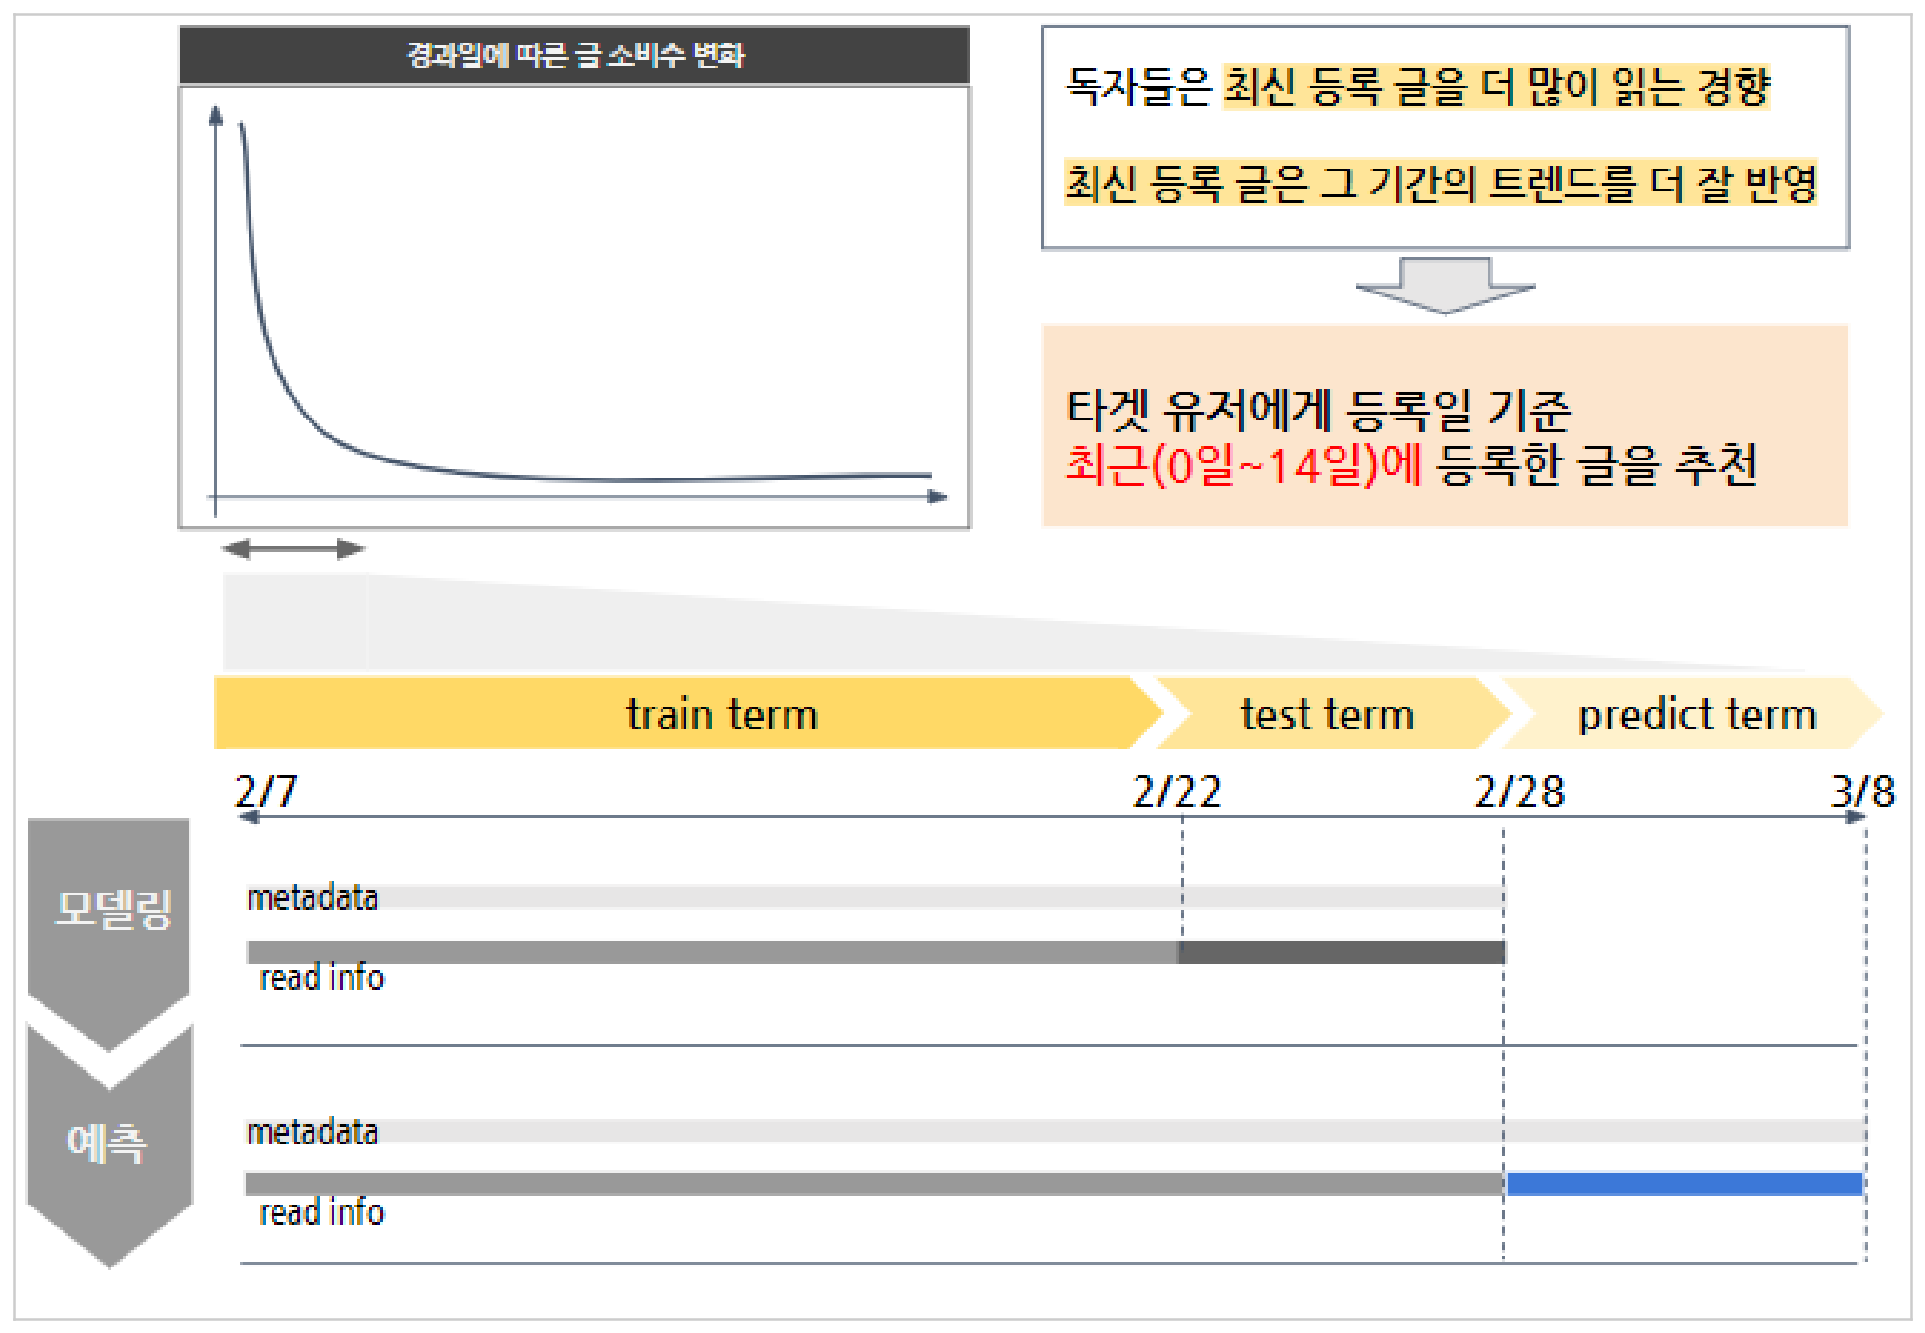

In [120]:
image = pilimg.open('train_test.png')
pix = np.array(image)
plt.figure(figsize=(30, 12))
plt.xticks([])
plt.yticks([])
plt.grid()
plt.imshow(pix)